In [1]:
#import all the libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, metrics

import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
# Supress Warnings
#Enable autocomplete in Jupyter Notebook.
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')
import os
import datetime

### Set seaborn style
sns.set(style="darkgrid")

## Set the max display columns to None so that pandas doesn't sandwich the output 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Helper Functions
Below are a few helper functions that we will use extensively in our notebook. These have been moved to the top to prevent the flow of our analysis.

In [2]:
### Let us create a utility function to generate a list of null values in different dataframes
### We will utilize this function extensively througout the notebook. 
def generateNullValuesPercentageTable(dataframe):
    totalNullValues = dataframe.isnull().sum().sort_values(ascending=False)
    percentageOfNullValues = round((dataframe.isnull().sum()*100/len(dataframe)).sort_values(ascending=False),2)
    columnNamesWithPrcntgOfNullValues = pd.concat([totalNullValues, percentageOfNullValues], axis=1, keys=['Total Null Values', 'Percentage of Null Values'])
    return columnNamesWithPrcntgOfNullValues

In [3]:
### let us create a reuseable function that will help us in ploting our barplots for analysis

def generateBarPlot(dataframe, keyVariable, plotSize):
    fig, axs = plt.subplots(figsize = plotSize)
    plt.xticks(rotation = 90)
    ax = sns.countplot(x=keyVariable, data=dataframe)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/len(dataframe) * 100),
                ha="center") 

In [4]:
### Let us define a reusable function to carry out Bivariate analysis as well.

def generateBiplot(df,col,title,figsize,hue=None):
    
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    plt.figure(figsize=figsize)
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,
                       palette='magma')
    
    convertcount=df.pivot_table(values='SalePrice',index=col,columns='SalePrice', aggfunc='count').fillna(0)
    convertcount["Conversion(%)"] =round(convertcount[1]/(convertcount[0]+convertcount[1]),2)*100
    return print(convertcount.sort_values(ascending=False,by="Conversion(%)"),plt.show())
        
    plt.show()

In [5]:
### Function to generate heatmaps

def generateHeatmaps(df, figsize):
    plt.figure(figsize = figsize)        # Size of the figure
    sns.heatmap(df.corr(),annot = True, annot_kws={"fontsize":7})


In [6]:
### Function to generate Boxplots
def generateBoxPlots(df, col, title, figsize):
    plt.figure(figsize=figsize)
    plt.xticks(rotation=45)
    sns.boxplot(data =df, x=col,y='SalePrice')
    plt.title(title)
    plt.show()

In [7]:
### Function to generate Regplots

def generateRegPlots(df, col, title, figsize):
    plt.figure(figsize=figsize)

    sns.regplot(x=housingDataSet[col], y=housingDataSet.SalePrice)
    plt.ylabel('SalePrice', fontsize= 10)
    plt.xlabel('GrLivArea', fontsize= 10)
    plt.title(title, fontsize= 12)
    plt.show()

In [8]:
# writing a function to check if a particular category has high skeweness(i.e. one of the level is contributing to >=80%)
# we'll drop such columns

def dropSkewedColumns(col_name,data):
    try:
        
        print(f"The data shape is {data.shape}")
        null = round(100*(data[col_name].isnull().sum(axis=0)/len(data)),2)
        my_dict = (data[col_name].value_counts(normalize=True)*100).to_dict()
        print(data[col_name].value_counts(normalize=True)*100)
        logic = list(map(lambda x:x>=80, my_dict.values()))
        
        if logic.count(True)>0:
            print(f'The data is highly skewed, so we will be dropping the column {col_name} and null% is {null}')
            data.drop(col_name,axis=1,inplace=True)
            print(f'The shape of data after dropping {col_name} is {data.shape}')
        elif logic.count(True)==0:
            print(f'The data is not highly skewed, so we will not be dropping the column {col_name} and null% is {null}')
            
    except:
        print(f'The {col_name} doesnot exist in the data or it might have been dropped, please recheck')
            

In [9]:
### Function to generate ROC curves
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [10]:
### Let us create a reusable function to calculate VIF values for our models

def vifCalculator(inputModel):
    vif= pd.DataFrame()
    X = inputModel
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


### Importing Data & Checking 

In [11]:
housingDataSet = pd.read_csv("./train.csv")
housingDataSet.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

# 1. Data Analysis and EDA
We will carry out some exploratory data analysis and understand the data better.

Steps taken:
-    Checking the shape, columns, datatypes etc. of the dataset
-    Assessing out of place values
-    Checking for duplicate values
-    Checking for null values
-    Dropping unnecessary columns
After this basic analysis we will carry out analysis of columns on individual basis and make a decision based on:

In [12]:
housingDataSet.shape

(1460, 81)

In [13]:
housingDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
housingDataSet.describe(percentiles=[0.15,0.35,0.55,0.75,0.95])

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
15%     219.850000    20.000000    50.000000    6120.000000     5.000000   
35%     511.650000    20.000000    60.000000    8450.000000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
55%     803.450000    60.000000    70.000000    9794.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
95%    1387.050000   160.000000   107.000000   17401.150000     8.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
15%       5.000000  1936.000000   1955.000000     0.000000     0.000000   
35%       5.000000  1961.000000   1976.000000     0.000000    56.650000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
55%       5.000000  1977.000000   1996.000000     0.000000   450.000000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
95%       8.000000  2007.000000   2007.000000   456.000000  1274.000000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
15%       0.000000   121.850000   701.700000   804.000000     0.000000   
35%       0.000000   320.650000   864.000000   959.650000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
55%       0.000000   544.000000  1040.000000  1132.450000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
95%     396.200000  1468.000000  1753.000000  1831.250000  1141.050000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
15%        0.000000   988.000000      0.000000      0.000000     1.000000   
35%        0.000000  1262.000000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
55%        0.000000  1509.450000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
95%        0.000000  2466.100000      1.000000      1.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
15%

#### Observation

Based on our basic exploration we can say that:

- The shape of the dataset is 1460 columns & 81 rows
- There are a few outliers in this dataset in various numerical columns. For example: LotFrontage, LotArea etc. 
- We have 43 object type columns which we will treat as categorical columns. 
- we have 38 numerical columns.

In [15]:
### Checking for null values

generateNullValuesPercentageTable(housingDataSet)

Total Null Values  Percentage of Null Values
PoolQC                      1453                      99.52
MiscFeature                 1406                      96.30
Alley                       1369                      93.77
Fence                       1179                      80.75
FireplaceQu                  690                      47.26
LotFrontage                  259                      17.74
GarageCond                    81                       5.55
GarageType                    81                       5.55
GarageYrBlt                   81                       5.55
GarageFinish                  81                       5.55
GarageQual                    81                       5.55
BsmtExposure                  38                       2.60
BsmtFinType2                  38                       2.60
BsmtFinType1                  37                       2.53
BsmtCond                      37                       2.53
BsmtQual                      37                       2.53
MasVnrArea                     8                       0.55
MasVnrType                     8                       0.55
Electrical                     1                       0.07
Utilities                      0                       0.00
YearRemodAdd                   0                       0.00
MSSubClass                     0                       0.00
Foundation                     0                       0.00
ExterCond                      0                       0.00
ExterQual                      0                       0.00
Exterior2nd                    0                       0.00
Exterior1st                    0                       0.00
RoofMatl                       0                       0.00
RoofStyle                      0                       0.00
YearBuilt                      0                       0.00
LotConfig                      0                       0.00
OverallCond                    0                       0.00
OverallQual                    0                       0.00
HouseStyle                     0                       0.00
BldgType                       0                       0.00
Condition2                     0                       0.00
BsmtFinSF1                     0                       0.00
MSZoning                       0                       0.00
LotArea                        0                       0.00
Street                         0                       0.00
Condition1                     0                       0.00
Neighborhood                   0                       0.00
LotShape                       0                       0.00
LandContour                    0                       0.00
LandSlope                      0                       0.00
SalePrice                      0                       0.00
HeatingQC                      0                       0.00
BsmtFinSF2                     0                       0.00
EnclosedPorch                  0                       0.00
Fireplaces                     0                       0.00
GarageCars                     0                       0.00
GarageArea                     0                       0.00
PavedDrive                     0                       0.00
WoodDeckSF                     0                       0.00
OpenPorchSF                    0                       0.00
3SsnPorch                      0                       0.00
BsmtUnfSF                      0                       0.00
ScreenPorch                    0                       0.00
PoolArea                       0                       0.00
MiscVal                        0                       0.00
MoSold                         0                       0.00
YrSold                         0                       0.00
SaleType                       0                       0.00
Functional                     0                       0.00
TotRmsAbvGrd                   0                       0.00
KitchenQual                    0                       

### Observation

There are a lot of columns with high percentage of null values. From the data dictionary we know that these can be treated as missing features. We shall do some further analysis before we impute these with any values. 


Let us individually assess the categorical and continuous columns through univariate, bivariate and multivariate analysis methods.

### Categorical Columns

### MSZoning

In [16]:
housingDataSet.MSZoning.describe()

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

In [17]:
housingDataSet.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

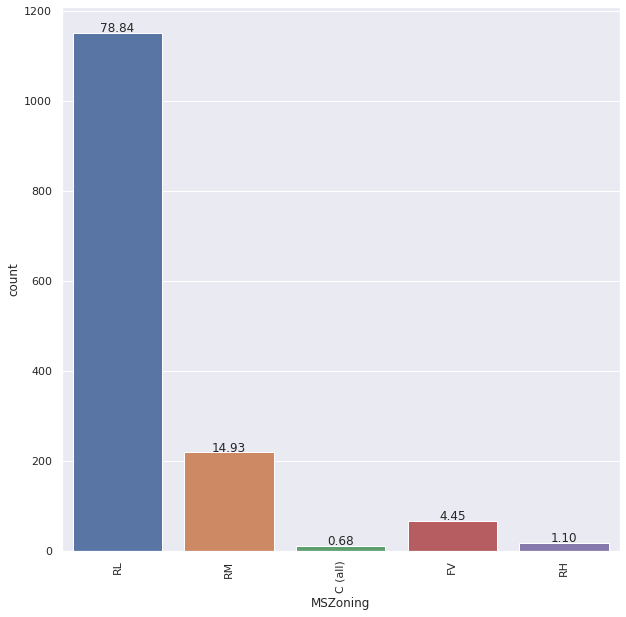

In [18]:
generateBarPlot(housingDataSet, 'MSZoning', (10,10))

### Observation

We can see from the barplot above that:

- 78.84% of the people live in the Residential Low Density zones
- Only 0.68% of the people live in Commercial zones
- We can consider binning the other categories as one because they form a fairly low percentage overall of the feature defined.

### Street

In [19]:
housingDataSet.Street.describe()

count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

In [20]:
housingDataSet.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

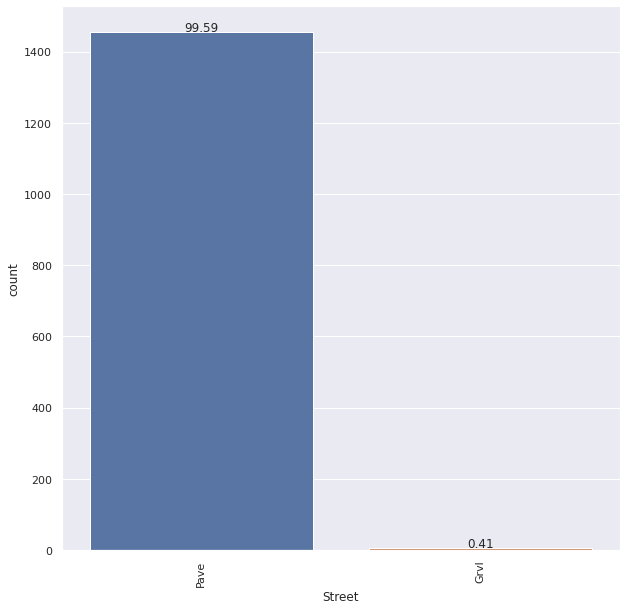

In [21]:
generateBarPlot(housingDataSet, 'Street', (10,10))

### Observation

From the barplot above we can see that the data is highly skewed towards the 'Pave'.

We will drop this column as a highly skewed column has the tendency to skew results. 

We will assess all our columns first before we drop any.

### Alley

In [22]:
housingDataSet.Alley.describe()

count       91
unique       2
top       Grvl
freq        50
Name: Alley, dtype: object

In [23]:
housingDataSet.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

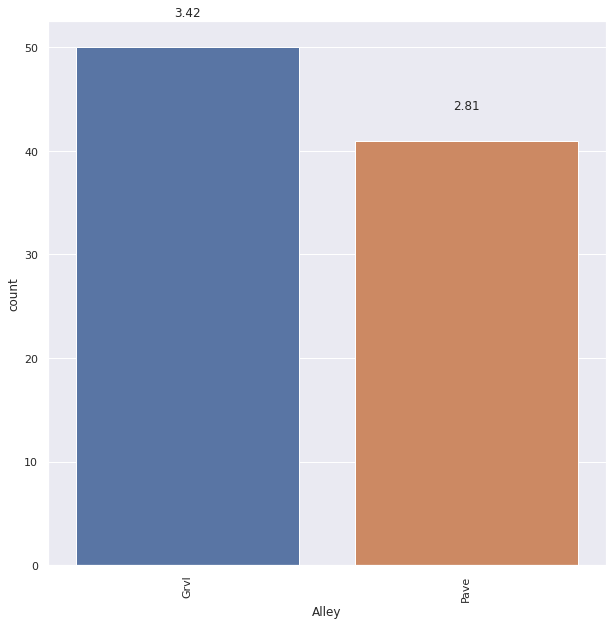

In [24]:
generateBarPlot(housingDataSet, 'Alley', (10,10))

### Observation

From the above barplot we can see that there is a discrepancy in the data. 

From our null value analysis we know that there is are over 90% null values in this column. 

We can therefore it is safe to consider dropping this variable.

### LotShape

In [25]:
housingDataSet.LotShape.describe()

count     1460
unique       4
top        Reg
freq       925
Name: LotShape, dtype: object

In [26]:
housingDataSet.LotShape.value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

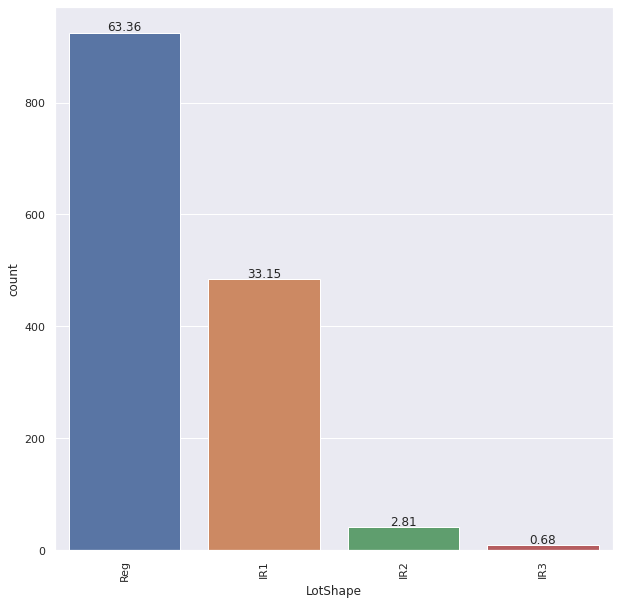

In [27]:
generateBarPlot(housingDataSet, 'LotShape', (10,10))

### Observation

From the barplot above we can see that:

- 63.36% of the people occupy regular shaped properties
- There are no null or missing values as the total of all the %values is 100


### LandContour

In [28]:
housingDataSet.LandContour.describe()

count     1460
unique       4
top        Lvl
freq      1311
Name: LandContour, dtype: object

In [29]:
housingDataSet.LandContour.value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

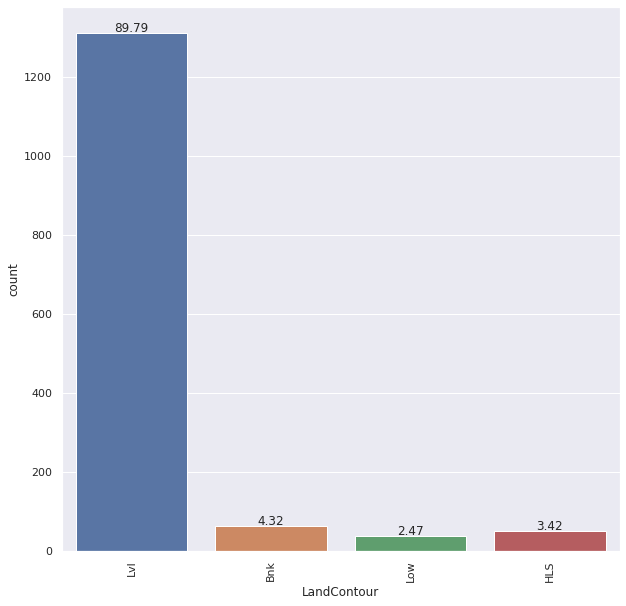

In [30]:
generateBarPlot(housingDataSet, 'LandContour', (10,10))

### Observation

From the barplot above we can see that the data is highly skewed in the Near Flat/Level section. It is safe to consider dropping this variable.

### Utilities

In [31]:
housingDataSet.Utilities.describe()

count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object

In [32]:
housingDataSet.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

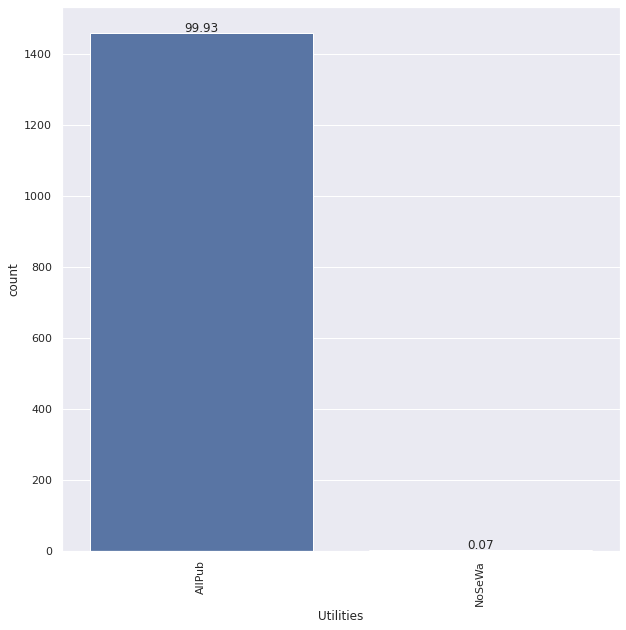

In [33]:
generateBarPlot(housingDataSet, 'Utilities', (10,10))

### Observation

From the barplot above we see that only 1 house does not have all the utilities available. This is again a highly skewed datapoint. It is safe to consider dropping this variable.

### LotConfig

In [34]:
housingDataSet.LotConfig.describe()

count       1460
unique         5
top       Inside
freq        1052
Name: LotConfig, dtype: object

In [35]:
housingDataSet.LotConfig.value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

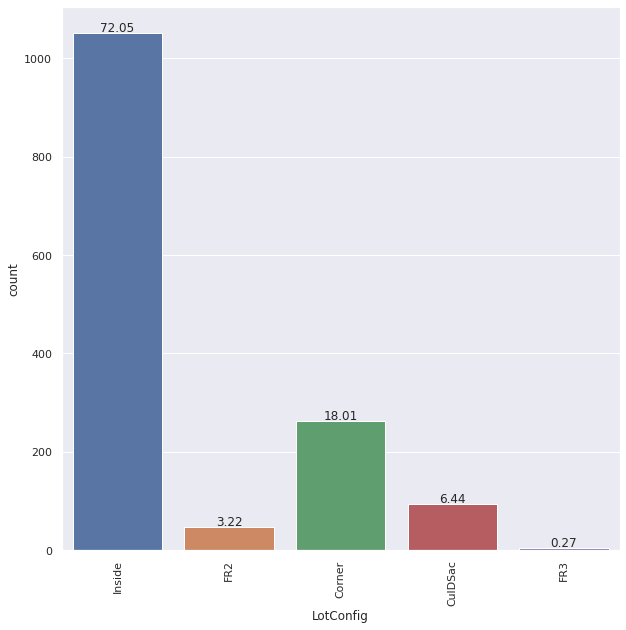

In [36]:
generateBarPlot(housingDataSet, 'LotConfig', (10,10))

### Observation

From the barplot above we can see that the data is slightly skewed, with 72% of it being an 'Inside Lot'

We can consider binning the categories with less than 10% of the data points together into a new category 'Others'

### LandSlope

In [37]:
housingDataSet.LandSlope.describe()

count     1460
unique       3
top        Gtl
freq      1382
Name: LandSlope, dtype: object

In [38]:
housingDataSet.LandSlope.value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

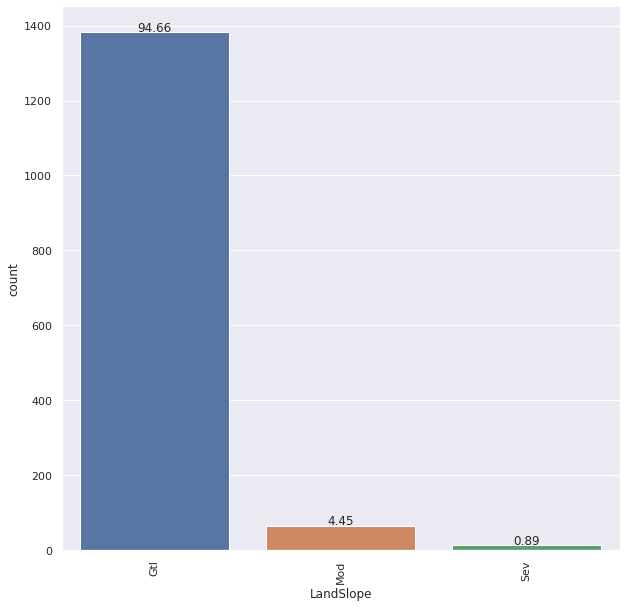

In [39]:
generateBarPlot(housingDataSet, 'LandSlope', (10,10))

### Observation

From the barplot above we can see that over 94% of the properties are on a Gentle Slope, with only 0.89% on a Severe slope. It is safe to consider dropping this variable since the data is so skewed.

### Neighborhood

In [40]:
housingDataSet.Neighborhood.describe()

count      1460
unique       25
top       NAmes
freq        225
Name: Neighborhood, dtype: object

In [41]:
housingDataSet.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

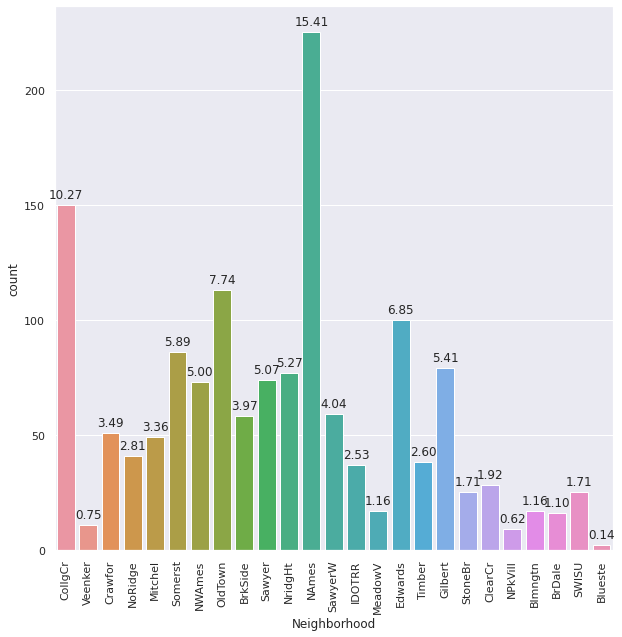

In [42]:
generateBarPlot(housingDataSet, 'Neighborhood', (10,10))

### Observation

From the barplot above we can see that:

- A lot of people prefer living in NAmes - North Ames in Sydney. 
- Only two people/families are living in Bluestem are.

It will be interesting to see the relationship this has with the sales pricing.

### HouseStyle

In [43]:
housingDataSet.HouseStyle.describe()

count       1460
unique         8
top       1Story
freq         726
Name: HouseStyle, dtype: object

In [44]:
housingDataSet.HouseStyle.value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

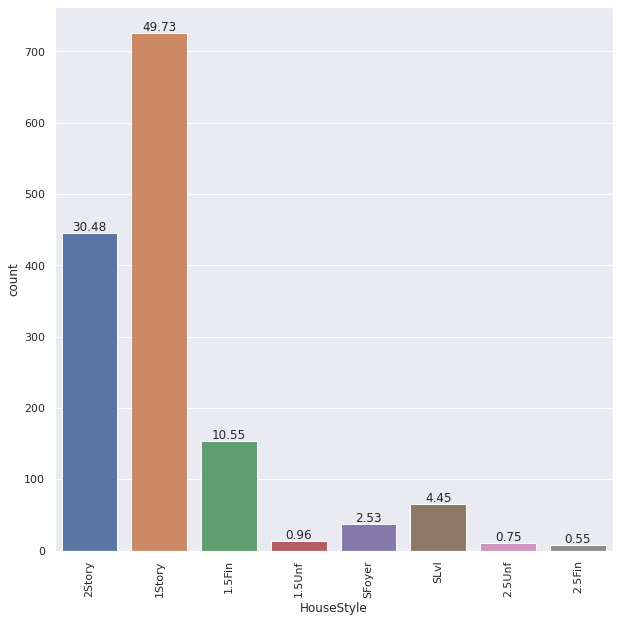

In [45]:
generateBarPlot(housingDataSet, 'HouseStyle', (10,10))

### Observation

From the above barplot we can see that:

- Most people prefer living in 1 story apartments
- Only a small number, 8, people/families prefer living in 2.5 story, furnished apartments.


### Continous Variables

In [46]:
housingDataSet.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

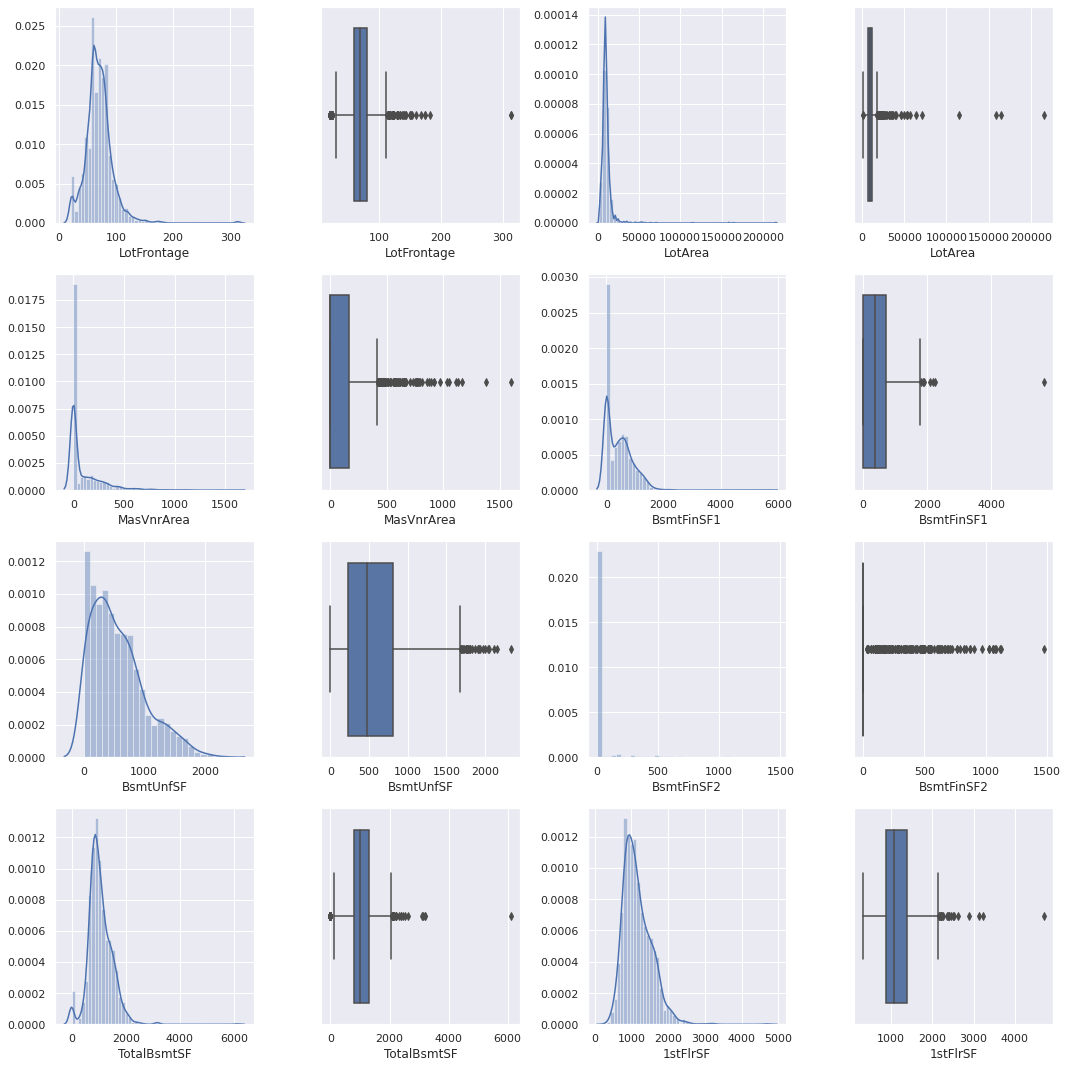

In [47]:
### We will not plot displots and barplot to assess all the numerical variables. We will be ignoring the ID feature.

fig, axs = plt.subplots(4,4, figsize = (15,15))


sns.distplot(housingDataSet['LotFrontage'], ax = axs[0,0])
sns.boxplot(housingDataSet['LotFrontage'], ax = axs[0,1])

plt3 = sns.distplot(housingDataSet['LotArea'], ax = axs[0,2])
plt4 = sns.boxplot(housingDataSet['LotArea'], ax = axs[0,3])

sns.distplot(housingDataSet['MasVnrArea'], ax = axs[1,0])
sns.boxplot(housingDataSet['MasVnrArea'], ax = axs[1,1])

sns.distplot(housingDataSet['BsmtFinSF1'], ax = axs[1,2])
sns.boxplot(housingDataSet['BsmtFinSF1'], ax = axs[1,3])

sns.distplot(housingDataSet['BsmtUnfSF'], ax = axs[2,0])
sns.boxplot(housingDataSet['BsmtUnfSF'], ax = axs[2,1])

## because of a library issue the below statements have been written slightly differently
sns.distplot(housingDataSet.BsmtFinSF2, ax= axs[2,2])
sns.boxplot(housingDataSet.BsmtFinSF2, ax= axs[2,3])

sns.distplot(housingDataSet['TotalBsmtSF'], ax = axs[3,0])
sns.boxplot(housingDataSet['TotalBsmtSF'], ax = axs[3,1])

sns.distplot(housingDataSet['1stFlrSF'], ax = axs[3,2])
sns.boxplot(housingDataSet['1stFlrSF'], ax = axs[3,3])


plt.tight_layout()

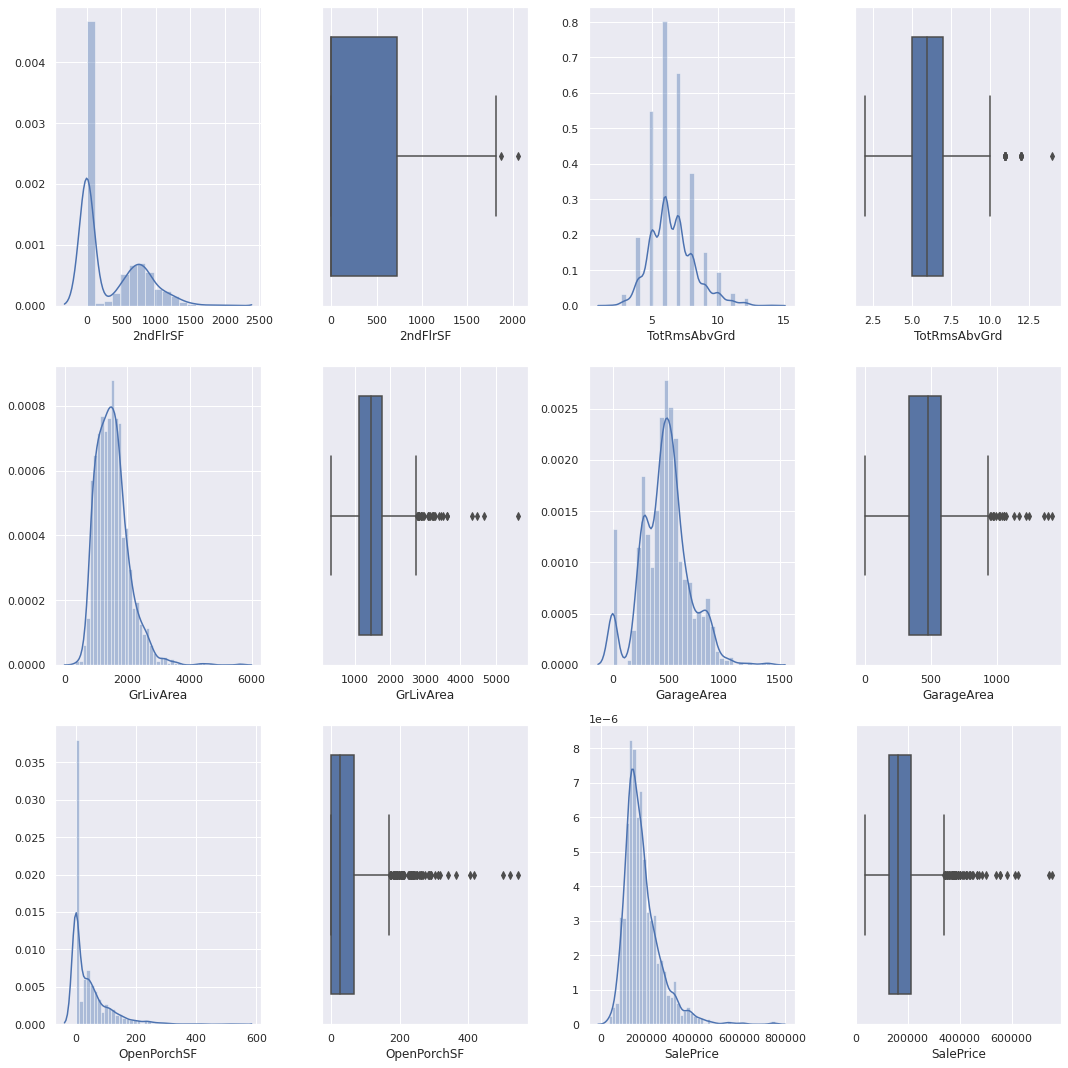

In [48]:
fig, axs = plt.subplots(3,4, figsize = (15,15))


plt1 = sns.distplot(housingDataSet['2ndFlrSF'], ax = axs[0,0])
plt2 = sns.boxplot(housingDataSet['2ndFlrSF'], ax = axs[0,1])

plt3 = sns.distplot(housingDataSet['TotRmsAbvGrd'], ax = axs[0,2])
plt4 = sns.boxplot(housingDataSet['TotRmsAbvGrd'], ax = axs[0,3])

plt5 = sns.distplot(housingDataSet['GrLivArea'], ax = axs[1,0])
plt6 = sns.boxplot(housingDataSet['GrLivArea'], ax = axs[1,1])

plt7 = sns.distplot(housingDataSet['GarageArea'], ax = axs[1,2])
plt8 = sns.boxplot(housingDataSet['GarageArea'], ax = axs[1,3])

plt9 = sns.distplot(housingDataSet['OpenPorchSF'], ax = axs[2,0])
plt10 = sns.boxplot(housingDataSet['OpenPorchSF'], ax = axs[2,1])

plt11 = sns.distplot(housingDataSet['SalePrice'], ax = axs[2,2])
plt12 = sns.boxplot(housingDataSet['SalePrice'], ax = axs[2,3])



plt.tight_layout()

### Observation

From the boxplots and displots for various variables we can observe:

- The target variable SalePrice is right skewed and has a few outlier present
- Most features seem to be right-skewed in nature with a few outliers present


We can cap the columns that have outliers and perform some outlier treatment on them. We will also try to transform the target variable so that we achieve a normal distribution.


## Bivatiate Analysis

To perform bivariate analysis we will take a subset of the numeric data columns from the original dataset.

In [49]:
### Creating new numeric dataset

housingDataSetNumericCols = housingDataSet.select_dtypes(include=['float64', 'int64'])
housingDataSetNumericCols.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          2003       196.0         706           0        150          856   
1          1976         0.0         978           0        284         1262   
2          2002       162.0         486           0        434          920   
3          1970         0.0         216           0        540          756   
4          2000       350.0         655           0        490         1145   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710             1             0   
1      1262         0             0       1262             0             1   
2       920       866             0       1786             1             0   
3       961       756             0       1717             1             0   
4      1145      1053             0       2198             1             0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         2         1             3             1             8           0   
1         2         0             3             1             6           1   
2         2         1             3             1             6           1   
3         1         0             3             1             7           1   
4         2         1             4             1             9           1   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0       2003.0           2         548           0           61   
1       1976.0           2         460         298            0   
2       2001.0           2         608           0           42   
3       1998.0           3         642           0           35   
4       2000.0           3         836         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000

In [50]:
housingDataSetNumericCols.shape

(1460, 38)

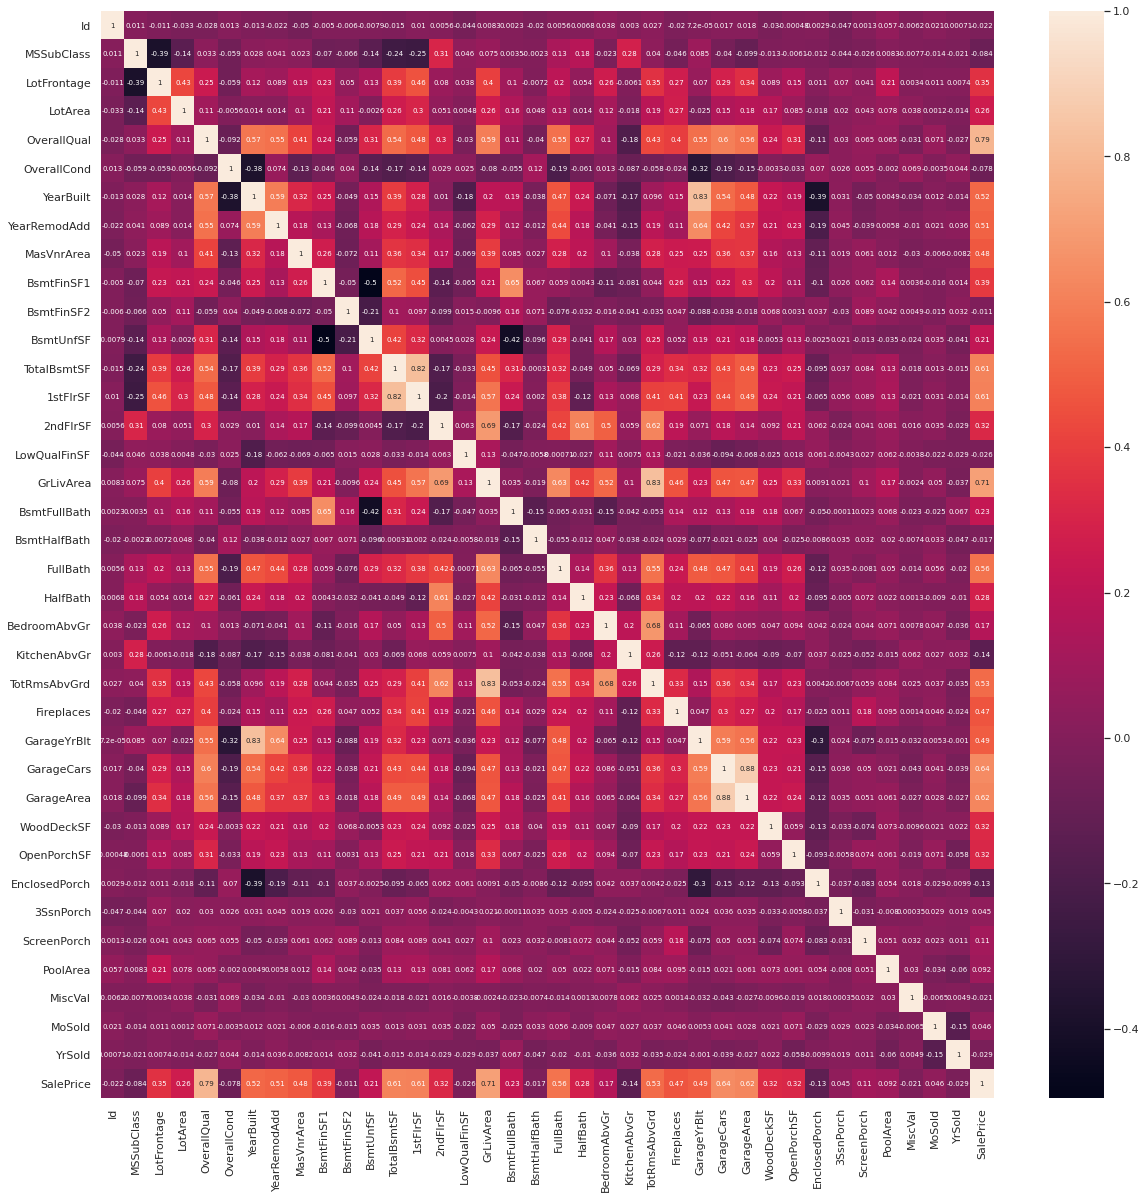

In [51]:
### Let us also generate a heatmap for the same
generateHeatmaps(housingDataSetNumericCols, (20,20))

### Observation

From the heatmap generated above we can see that some variables are strongly correlated with SalePrice.

- Specifically, these six features : OverallQual, GrlivArea, TotalBsmtSF, 1stFLrSF, GarageCars, and GrageArea. 

- There is also strong correlation between some variables, this suggests multicolinearity. There is a strong correlation between Yearbuilt and GarageYrBlt which means that most Garages are built in the same time with the construction of the houses. Therefeore,we can consider that Yearbuilt and GarageYrBlt as the same variable. 

- SalePrice is negatively correlated to KitchenAbvGr and EnclosedPorch

Let us plot a pairplot of some of the most correlated features with the SalePrice

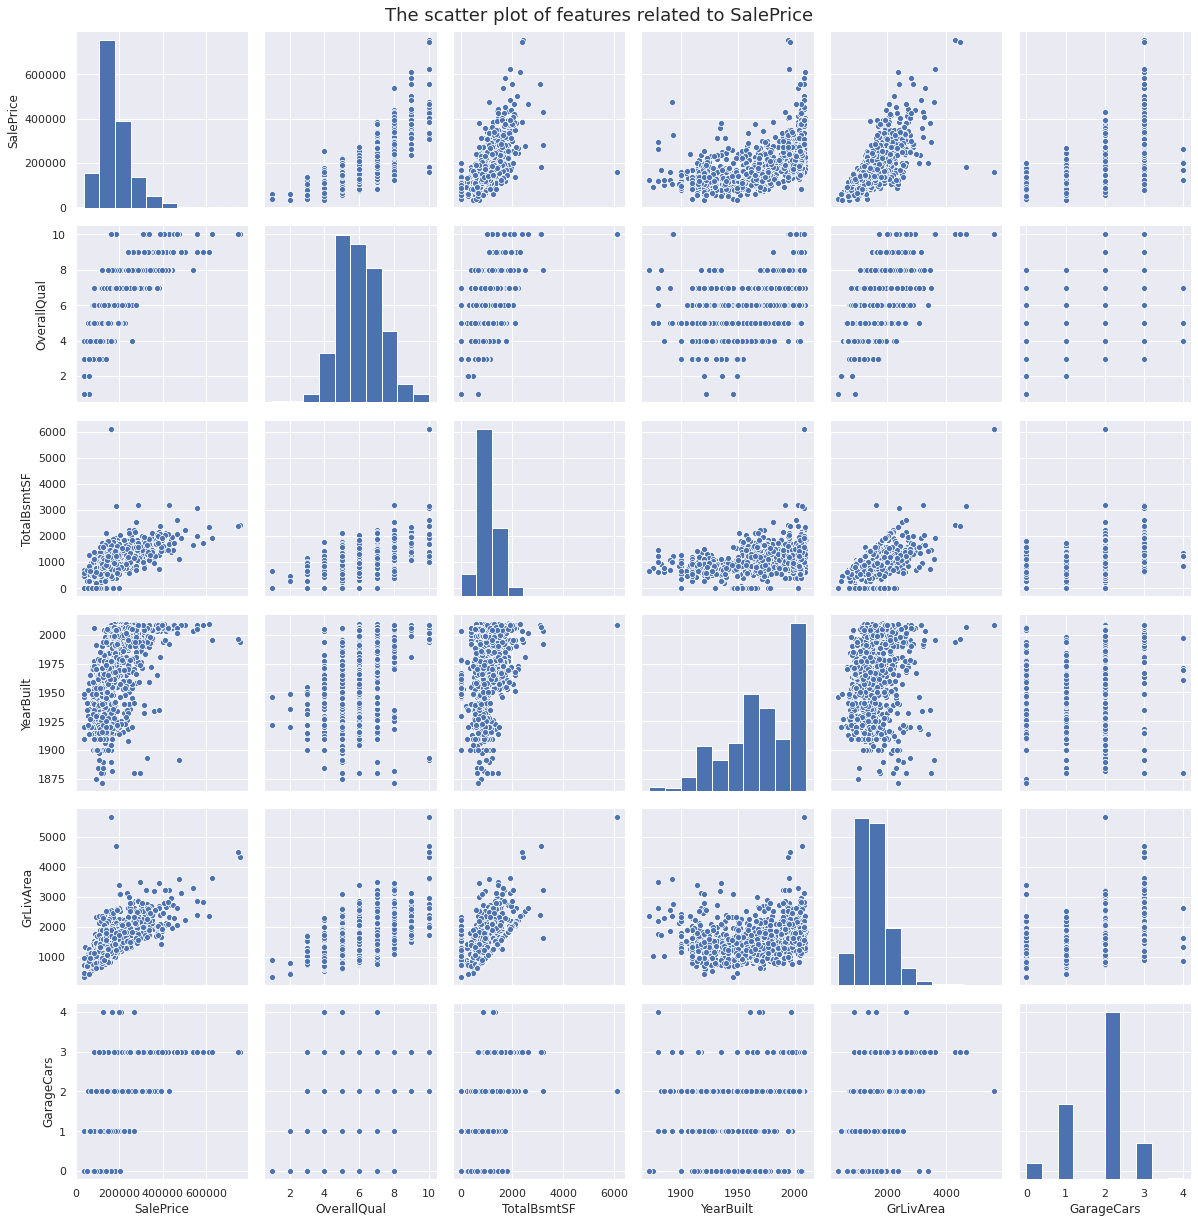

In [52]:
#Scatter plot of the most important features
corelatedCols = ['SalePrice', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'GrLivArea', 'GarageCars']
sns.pairplot(housingDataSetNumericCols[corelatedCols], size = 2.8)
plt.suptitle('The scatter plot of features related to SalePrice',x=0.5, y=1.01, verticalalignment='top', fontsize= 18)
plt.tight_layout()
plt.show()

### Observation

From the pairplot above we can see that there are a few outliers in the features TotalBamtSF & GrLivArea. Let us take a closer look ath them using a regplot.

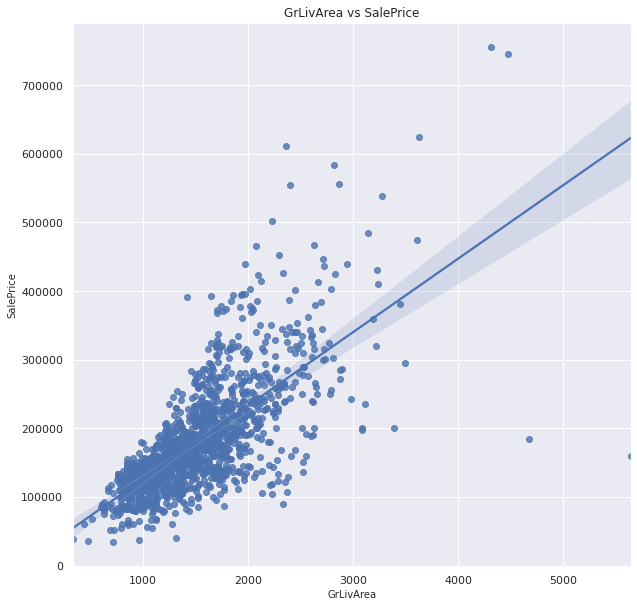

In [53]:
generateRegPlots(housingDataSet, 'GrLivArea', 'GrLivArea vs SalePrice', (10,10))

### Observation

From the above regplot we can see that there are 2 points that are Ground living area but have a very low SalePrice. they are clearly outliers and we will be removing them. 

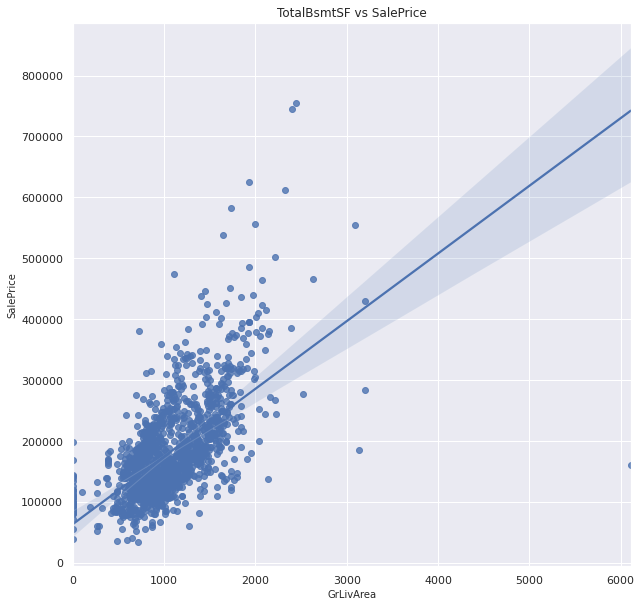

In [54]:
generateRegPlots(housingDataSet, 'TotalBsmtSF', 'TotalBsmtSF vs SalePrice', (10,10))

### Observation

There seems to be only one outlier, we can cap it if we choose. 

#### Plotting Continous - Categorical Variables

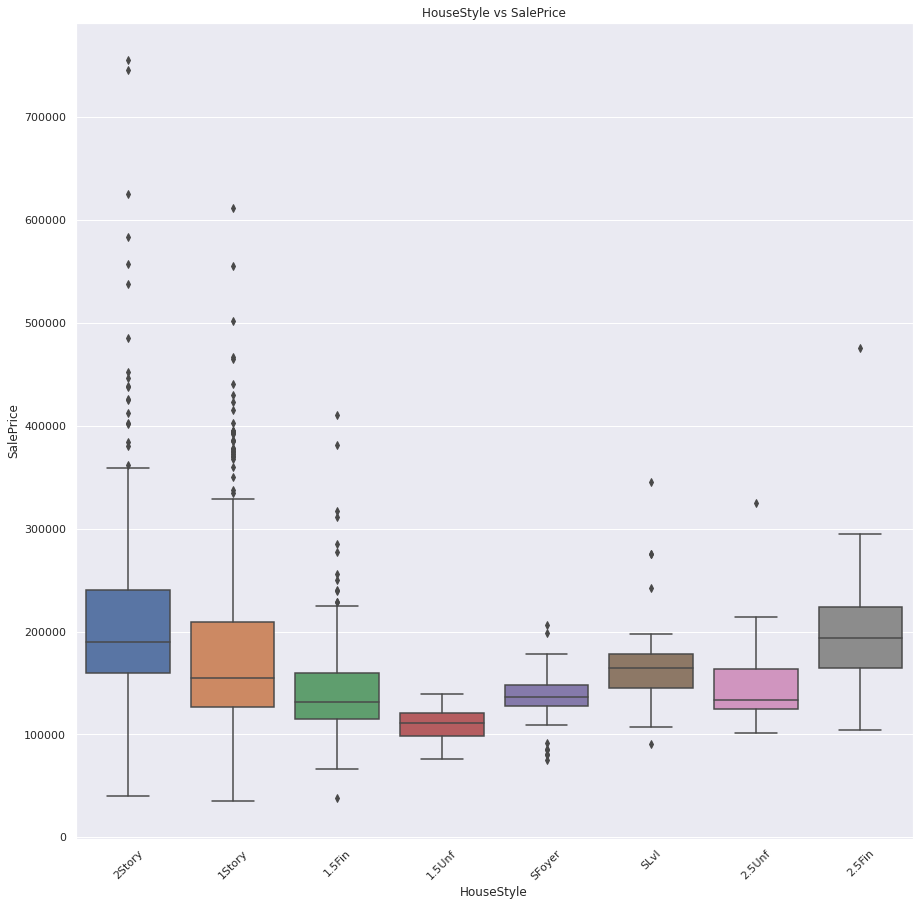

In [55]:
generateBoxPlots(housingDataSet, 'HouseStyle', 'HouseStyle vs SalePrice', (15,15))

### Observation

As we can see from the boxplot above"
- 2Story has the highlest range of SalePrice. They range from a very low SalePrice to a very high SalePrice
- Overall 1.5Unf has the lowest median prices of sale 

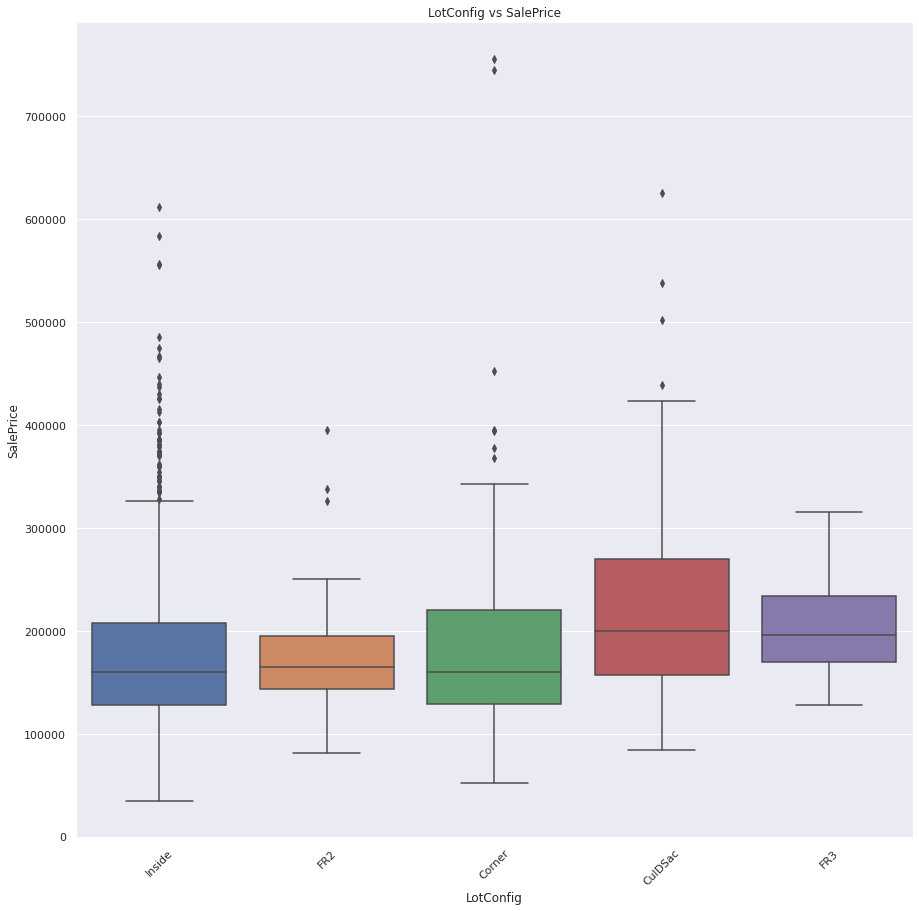

In [56]:
generateBoxPlots(housingDataSet, 'LotConfig','LotConfig vs SalePrice', (15,15))

### Observation

From the boxplot above we can say that:

- Properties with a Corner LotConfig have a few outliers
- Inside LotConfig Properties have a series of outliers that are relatively close to each other


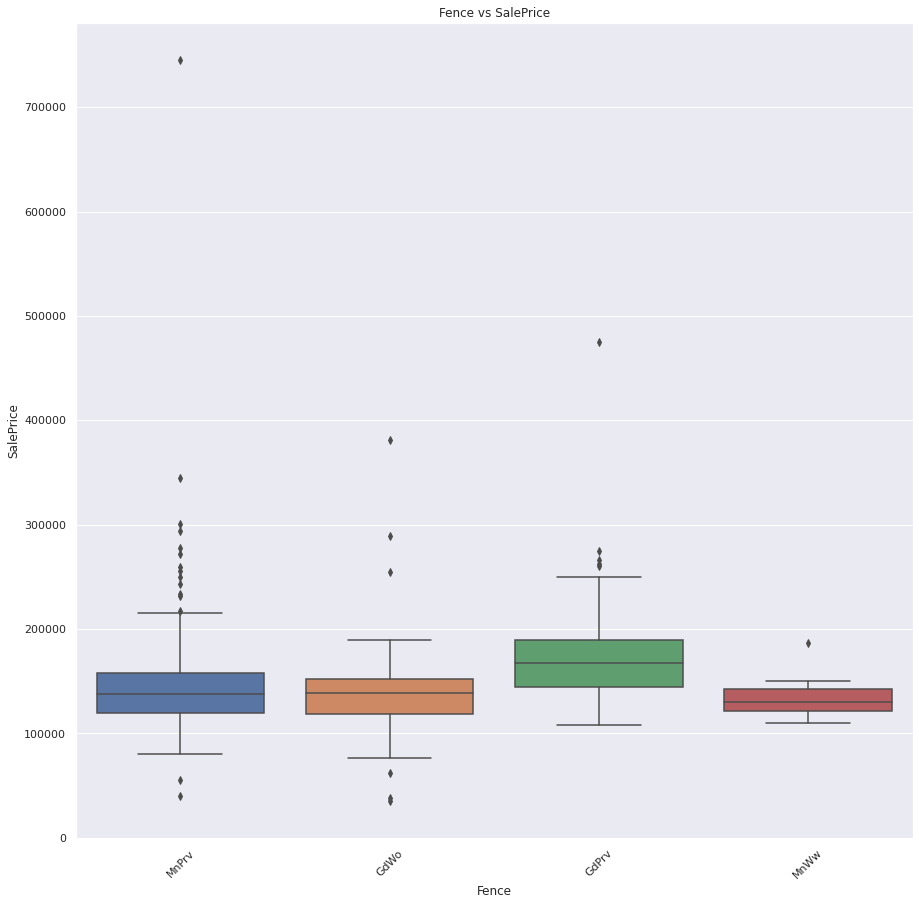

In [57]:
generateBoxPlots(housingDataSet, 'Fence','Fence vs SalePrice', (15,15))

### Observations

Fromt he boxplot above we can see that:

- Properties with Good Privacy have the best median sales price
- There are a few outliers in the properties that have minimum privacy as well
- The properties with Good Wooden fences and Minimum Privacy have relatively similar median prices

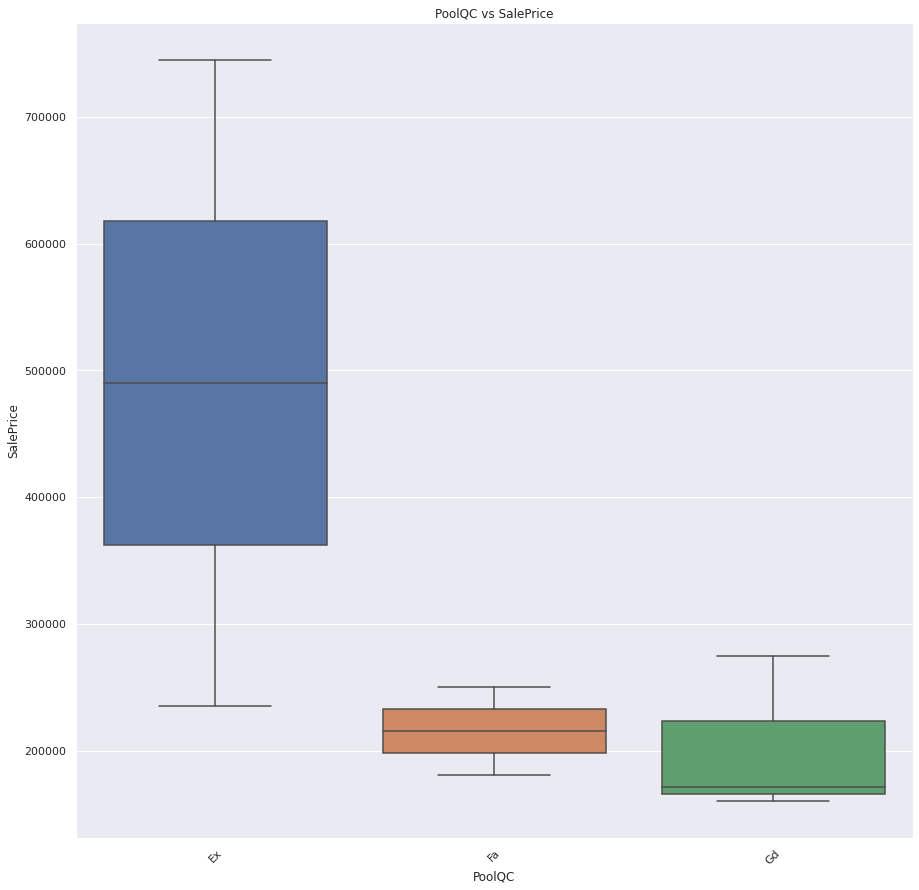

In [58]:
generateBoxPlots(housingDataSet, 'PoolQC','PoolQC vs SalePrice', (15,15))

### Observation

We can clearly see that properties with an Excellent pool quality go at the highest prices

### Note:

Now we will assess the columns with a high number of NaN values and impute them correctly:


In [59]:
### generate null values again
generateNullValuesPercentageTable(housingDataSet)

Total Null Values  Percentage of Null Values
PoolQC                      1453                      99.52
MiscFeature                 1406                      96.30
Alley                       1369                      93.77
Fence                       1179                      80.75
FireplaceQu                  690                      47.26
LotFrontage                  259                      17.74
GarageCond                    81                       5.55
GarageType                    81                       5.55
GarageYrBlt                   81                       5.55
GarageFinish                  81                       5.55
GarageQual                    81                       5.55
BsmtExposure                  38                       2.60
BsmtFinType2                  38                       2.60
BsmtFinType1                  37                       2.53
BsmtCond                      37                       2.53
BsmtQual                      37                       2.53
MasVnrArea                     8                       0.55
MasVnrType                     8                       0.55
Electrical                     1                       0.07
Utilities                      0                       0.00
YearRemodAdd                   0                       0.00
MSSubClass                     0                       0.00
Foundation                     0                       0.00
ExterCond                      0                       0.00
ExterQual                      0                       0.00
Exterior2nd                    0                       0.00
Exterior1st                    0                       0.00
RoofMatl                       0                       0.00
RoofStyle                      0                       0.00
YearBuilt                      0                       0.00
LotConfig                      0                       0.00
OverallCond                    0                       0.00
OverallQual                    0                       0.00
HouseStyle                     0                       0.00
BldgType                       0                       0.00
Condition2                     0                       0.00
BsmtFinSF1                     0                       0.00
MSZoning                       0                       0.00
LotArea                        0                       0.00
Street                         0                       0.00
Condition1                     0                       0.00
Neighborhood                   0                       0.00
LotShape                       0                       0.00
LandContour                    0                       0.00
LandSlope                      0                       0.00
SalePrice                      0                       0.00
HeatingQC                      0                       0.00
BsmtFinSF2                     0                       0.00
EnclosedPorch                  0                       0.00
Fireplaces                     0                       0.00
GarageCars                     0                       0.00
GarageArea                     0                       0.00
PavedDrive                     0                       0.00
WoodDeckSF                     0                       0.00
OpenPorchSF                    0                       0.00
3SsnPorch                      0                       0.00
BsmtUnfSF                      0                       0.00
ScreenPorch                    0                       0.00
PoolArea                       0                       0.00
MiscVal                        0                       0.00
MoSold                         0                       0.00
YrSold                         0                       0.00
SaleType                       0                       0.00
Functional                     0                       0.00
TotRmsAbvGrd                   0                       0.00
KitchenQual                    0                       

In [60]:
### Impute columns that have Nan values based on our understanding from the data dictionary with NO

#Alley
housingDataSet.Alley.fillna(inplace=True,value='No')
#BsmtQual
housingDataSet.BsmtQual.fillna(inplace=True,value='No')
#BsmtCond
housingDataSet.BsmtCond.fillna(inplace=True,value='No')
#BsmtExposure
housingDataSet.BsmtExposure.fillna(inplace=True,value='No')
#BsmtFinType1
housingDataSet.BsmtFinType1.fillna(inplace=True,value='No')
#BsmtFinType2
housingDataSet.BsmtFinType2.fillna(inplace=True,value='No')
#FireplaceQu
housingDataSet.FireplaceQu.fillna(inplace=True,value='No') 
#GarageType
housingDataSet.GarageType.fillna(inplace=True,value='No')
#GarageFinish
housingDataSet.GarageFinish.fillna(inplace=True,value='No')
#GarageQual 
housingDataSet.GarageQual.fillna(inplace=True,value='No')    
#GarageCond
housingDataSet.GarageCond.fillna(inplace=True,value='No')
#PoolQC
housingDataSet.PoolQC.fillna(inplace=True,value='No')    
#Fence
housingDataSet.Fence.fillna(inplace=True,value='No')
#MiscFeature
housingDataSet.MiscFeature.fillna(inplace=True,value='No')

### generate null values table again
generateNullValuesPercentageTable(housingDataSet)

Total Null Values  Percentage of Null Values
LotFrontage                  259                      17.74
GarageYrBlt                   81                       5.55
MasVnrType                     8                       0.55
MasVnrArea                     8                       0.55
Electrical                     1                       0.07
SalePrice                      0                       0.00
ExterCond                      0                       0.00
RoofStyle                      0                       0.00
RoofMatl                       0                       0.00
Exterior1st                    0                       0.00
Exterior2nd                    0                       0.00
ExterQual                      0                       0.00
BsmtQual                       0                       0.00
Foundation                     0                       0.00
BsmtCond                       0                       0.00
BsmtExposure                   0                       0.00
BsmtFinType1                   0                       0.00
BsmtFinSF1                     0                       0.00
BsmtFinType2                   0                       0.00
BsmtFinSF2                     0                       0.00
YearRemodAdd                   0                       0.00
YearBuilt                      0                       0.00
TotalBsmtSF                    0                       0.00
Utilities                      0                       0.00
MSSubClass                     0                       0.00
MSZoning                       0                       0.00
LotArea                        0                       0.00
Street                         0                       0.00
Alley                          0                       0.00
LotShape                       0                       0.00
LandContour                    0                       0.00
LotConfig                      0                       0.00
OverallCond                    0                       0.00
LandSlope                      0                       0.00
Neighborhood                   0                       0.00
Condition1                     0                       0.00
Condition2                     0                       0.00
BldgType                       0                       0.00
HouseStyle                     0                       0.00
OverallQual                    0                       0.00
BsmtUnfSF                      0                       0.00
HeatingQC                      0                       0.00
Heating                        0                       0.00
ScreenPorch                    0                       0.00
GarageQual                     0                       0.00
GarageCond                     0                       0.00
PavedDrive                     0                       0.00
WoodDeckSF                     0                       0.00
OpenPorchSF                    0                       0.00
EnclosedPorch                  0                       0.00
3SsnPorch                      0                       0.00
PoolArea                       0                       0.00
GarageCars                     0                       0.00
PoolQC                         0                       0.00
Fence                          0                       0.00
MiscFeature                    0                       0.00
MiscVal                        0                       0.00
MoSold                         0                       0.00
YrSold                         0                       0.00
SaleType                       0                       0.00
GarageArea                     0                       0.00
GarageFinish                   0                       0.00
SaleCondition                  0                       0.00
FullBath                       0                       0.00
CentralAir                     0                       0.00
1stFlrSF                       0                       

### Observation

As you can see, after we imputed the values with 'No' the columns with a high number of null values changed.

We will now check for row wise null values and consider dropping any rows that have a high number/more than 5% of null values in them.

In [61]:
housingDataSet.isnull().sum(axis=1).sort_values(ascending=False)

529     3
234     3
393     2
1030    2
977     2
307     2
973     2
1278    2
1143    2
287     2
375     2
1243    2
936     2
1407    2
650     2
490     1
218     1
1177    1
789     1
214     1
1173    1
237     1
1146    1
221     1
1164    1
794     1
1153    1
1154    1
495     1
496     1
1161    1
791     1
1148    1
811     1
1141    1
1180    1
269     1
470     1
1108    1
1110    1
828     1
826     1
1116    1
822     1
1122    1
1123    1
1124    1
250     1
249     1
817     1
816     1
1131    1
484     1
244     1
241     1
1137    1
1138    1
1179    1
784     1
210     1
208     1
170     1
169     1
1230    1
535     1
166     1
1233    1
1234    1
165     1
163     1
537     1
751     1
160     1
750     1
538     1
1244    1
539     1
1247    1
155     1
746     1
153     1
1251    1
533     1
757     1
177     1
516     1
207     1
785     1
1097    1
783     1
203     1
1190    1
1193    1
198     1
392     1
518     1
1219    1
191     1
520     1
770     1


### Observation

There arent a lot of rows with a high number of null values. So no rows will be dropped. 

We will now deal with the null values in the data set.

We will impute the null values of the Categorical columns with the Mode value and for the Continuous columns with the median or mean values. 

In [62]:
### Replacing na with Median value in LotFrontage column

housingDataSet.LotFrontage = housingDataSet.LotFrontage.fillna(housingDataSet.LotFrontage.median())

In [63]:
### Imputing values for MasVnrArea
housingDataSet.MasVnrArea = housingDataSet.MasVnrArea.fillna(housingDataSet.MasVnrArea.median())

In [64]:
generateNullValuesPercentageTable(housingDataSet)

Total Null Values  Percentage of Null Values
GarageYrBlt                   81                       5.55
MasVnrType                     8                       0.55
Electrical                     1                       0.07
SalePrice                      0                       0.00
ExterCond                      0                       0.00
RoofStyle                      0                       0.00
RoofMatl                       0                       0.00
Exterior1st                    0                       0.00
Exterior2nd                    0                       0.00
MasVnrArea                     0                       0.00
ExterQual                      0                       0.00
Foundation                     0                       0.00
BsmtQual                       0                       0.00
BsmtCond                       0                       0.00
BsmtExposure                   0                       0.00
BsmtFinType1                   0                       0.00
BsmtFinSF1                     0                       0.00
BsmtFinType2                   0                       0.00
BsmtFinSF2                     0                       0.00
YearRemodAdd                   0                       0.00
YearBuilt                      0                       0.00
TotalBsmtSF                    0                       0.00
OverallCond                    0                       0.00
MSSubClass                     0                       0.00
MSZoning                       0                       0.00
LotFrontage                    0                       0.00
LotArea                        0                       0.00
Street                         0                       0.00
Alley                          0                       0.00
LotShape                       0                       0.00
LandContour                    0                       0.00
Utilities                      0                       0.00
LotConfig                      0                       0.00
LandSlope                      0                       0.00
Neighborhood                   0                       0.00
Condition1                     0                       0.00
Condition2                     0                       0.00
BldgType                       0                       0.00
HouseStyle                     0                       0.00
OverallQual                    0                       0.00
BsmtUnfSF                      0                       0.00
HeatingQC                      0                       0.00
Heating                        0                       0.00
ScreenPorch                    0                       0.00
GarageQual                     0                       0.00
GarageCond                     0                       0.00
PavedDrive                     0                       0.00
WoodDeckSF                     0                       0.00
OpenPorchSF                    0                       0.00
EnclosedPorch                  0                       0.00
3SsnPorch                      0                       0.00
PoolArea                       0                       0.00
GarageCars                     0                       0.00
PoolQC                         0                       0.00
Fence                          0                       0.00
MiscFeature                    0                       0.00
MiscVal                        0                       0.00
MoSold                         0                       0.00
YrSold                         0                       0.00
SaleType                       0                       0.00
GarageArea                     0                       0.00
GarageFinish                   0                       0.00
SaleCondition                  0                       0.00
FullBath                       0                       0.00
CentralAir                     0                       0.00
1stFlrSF                       0                       

### Observation

As you can see above, we have successfully imputed the Na values with the median values. 

In [65]:
### Imputing values for MasVnrType
housingDataSet.MasVnrType.value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [66]:
### We will impute these values with the mode value for MasVnrType
housingDataSet.MasVnrType = housingDataSet.MasVnrType.fillna('None')
housingDataSet.MasVnrType.value_counts(dropna=False)

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [67]:
### Imputing values for 'Electrical'
housingDataSet.Electrical.value_counts(dropna=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [68]:
housingDataSet.Electrical = housingDataSet.Electrical.fillna('SBrkr')
housingDataSet.Electrical.value_counts(dropna=False)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [69]:
### Imputing values for GarageYrBlt. Since this is a numerical column we will convert it to object tyoe first

housingDataSet.GarageYrBlt = housingDataSet.GarageYrBlt.astype('object')
housingDataSet.GarageYrBlt.value_counts(dropna=False)

NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
1977.0    35
1998.0    31
1999.0    30
2008.0    29
1976.0    29
2000.0    27
2002.0    26
1968.0    26
1950.0    24
1993.0    22
1962.0    21
2009.0    21
1965.0    21
1966.0    21
1958.0    21
1970.0    20
1996.0    20
2001.0    20
1957.0    20
1978.0    19
1960.0    19
1954.0    19
1997.0    19
1964.0    18
1974.0    18
1995.0    18
1994.0    18
1959.0    17
1990.0    16
1963.0    16
1956.0    16
1969.0    15
1967.0    15
1979.0    15
1980.0    15
1988.0    14
1972.0    14
1940.0    14
1920.0    14
1973.0    14
1955.0    13
1961.0    13
1971.0    13
1992.0    13
1953.0    12
1987.0    11
1948.0    11
1941.0    10
1925.0    10
1989.0    10
1985.0    10
1981.0    10
1991.0     9
1975.0     9
1939.0     9
1984.0     8
1949.0     8
1930.0     8
1983.0     7
1986.0     6
1951.0     6
1926.0     6
1916.0     5
1922.0     5
1936.0     5
1928.0     4
1931.0     4
1935.0     4
1982.0     4
1945.0     4
1946.0     4

In [70]:
housingDataSet.GarageYrBlt = housingDataSet.GarageYrBlt.fillna(2005.0)
housingDataSet.GarageYrBlt.value_counts(dropna=False)

2005.0    146
2006.0     59
2004.0     53
2003.0     50
2007.0     49
1977.0     35
1998.0     31
1999.0     30
2008.0     29
1976.0     29
2000.0     27
2002.0     26
1968.0     26
1950.0     24
1993.0     22
2009.0     21
1965.0     21
1966.0     21
1962.0     21
1958.0     21
2001.0     20
1996.0     20
1957.0     20
1970.0     20
1960.0     19
1997.0     19
1978.0     19
1954.0     19
1974.0     18
1994.0     18
1995.0     18
1964.0     18
1959.0     17
1963.0     16
1990.0     16
1956.0     16
1969.0     15
1979.0     15
1980.0     15
1967.0     15
1988.0     14
1973.0     14
1940.0     14
1920.0     14
1972.0     14
1961.0     13
1971.0     13
1955.0     13
1992.0     13
1953.0     12
1987.0     11
1948.0     11
1985.0     10
1981.0     10
1941.0     10
1925.0     10
1989.0     10
1975.0      9
1991.0      9
1939.0      9
1984.0      8
1949.0      8
1930.0      8
1983.0      7
1986.0      6
1951.0      6
1926.0      6
1922.0      5
1936.0      5
1916.0      5
1931.0      4
1945.0

In [71]:
generateNullValuesPercentageTable(housingDataSet)

Total Null Values  Percentage of Null Values
SalePrice                      0                        0.0
Heating                        0                        0.0
RoofStyle                      0                        0.0
RoofMatl                       0                        0.0
Exterior1st                    0                        0.0
Exterior2nd                    0                        0.0
MasVnrType                     0                        0.0
MasVnrArea                     0                        0.0
ExterQual                      0                        0.0
ExterCond                      0                        0.0
Foundation                     0                        0.0
BsmtQual                       0                        0.0
BsmtCond                       0                        0.0
BsmtExposure                   0                        0.0
BsmtFinType1                   0                        0.0
BsmtFinSF1                     0                        0.0
BsmtFinType2                   0                        0.0
BsmtFinSF2                     0                        0.0
BsmtUnfSF                      0                        0.0
YearRemodAdd                   0                        0.0
YearBuilt                      0                        0.0
OverallCond                    0                        0.0
LandContour                    0                        0.0
MSSubClass                     0                        0.0
MSZoning                       0                        0.0
LotFrontage                    0                        0.0
LotArea                        0                        0.0
Street                         0                        0.0
Alley                          0                        0.0
LotShape                       0                        0.0
Utilities                      0                        0.0
OverallQual                    0                        0.0
LotConfig                      0                        0.0
LandSlope                      0                        0.0
Neighborhood                   0                        0.0
Condition1                     0                        0.0
Condition2                     0                        0.0
BldgType                       0                        0.0
HouseStyle                     0                        0.0
TotalBsmtSF                    0                        0.0
HeatingQC                      0                        0.0
SaleCondition                  0                        0.0
CentralAir                     0                        0.0
GarageArea                     0                        0.0
GarageQual                     0                        0.0
GarageCond                     0                        0.0
PavedDrive                     0                        0.0
WoodDeckSF                     0                        0.0
OpenPorchSF                    0                        0.0
EnclosedPorch                  0                        0.0
3SsnPorch                      0                        0.0
ScreenPorch                    0                        0.0
PoolArea                       0                        0.0
PoolQC                         0                        0.0
Fence                          0                        0.0
MiscFeature                    0                        0.0
MiscVal                        0                        0.0
MoSold                         0                        0.0
YrSold                         0                        0.0
SaleType                       0                        0.0
GarageCars                     0                        0.0
GarageFinish                   0                        0.0
GarageYrBlt                    0                        0.0
FullBath                       0                        0.0
Electrical                     0                        0.0
1stFlrSF                       0                       

### Observation

From the above we can see that there are no more null values present.

We will now convert some numerical columns into categorical columns.

In [72]:
housingDataSet['MSSubClass'] =  housingDataSet['MSSubClass'].astype('object')
housingDataSet['OverallQual'] =  housingDataSet['OverallQual'].astype('object')
housingDataSet['OverallCond'] =  housingDataSet['OverallCond'].astype('object')
housingDataSet['BsmtFullBath'] =  housingDataSet['BsmtFullBath'].astype('object')
housingDataSet['BsmtHalfBath'] =  housingDataSet['BsmtHalfBath'].astype('object')
housingDataSet['FullBath'] =  housingDataSet['FullBath'].astype('object')
housingDataSet['HalfBath'] =  housingDataSet['HalfBath'].astype('object')
housingDataSet['BedroomAbvGr'] =  housingDataSet['BedroomAbvGr'].astype('object')
housingDataSet['KitchenAbvGr'] =  housingDataSet['KitchenAbvGr'].astype('object')
housingDataSet['TotRmsAbvGrd'] =  housingDataSet['TotRmsAbvGrd'].astype('object')
housingDataSet['Fireplaces'] =  housingDataSet['Fireplaces'].astype('object')
housingDataSet['GarageCars'] =  housingDataSet['GarageCars'].astype('object')

In [73]:
# Let's just convert the categorical 'GarageYrBlt' back to continuous variable so that age calculation can be done on it

housingDataSet.GarageYrBlt = housingDataSet.GarageYrBlt.astype('float64')

In [74]:
# Creating some derived features 

now = datetime.datetime.now()

housingDataSet['Age_SinceConstruction'] = housingDataSet['YearBuilt'].apply(lambda x: now.year - x)
housingDataSet['Age_Remodel'] = housingDataSet['YearRemodAdd'].apply(lambda x: now.year - x)
housingDataSet['Age_Garage'] = housingDataSet['GarageYrBlt'].apply(lambda x: now.year - x)
housingDataSet['Age_SinceSold'] = housingDataSet['YrSold'].apply(lambda x: now.year - x)


In [75]:
housingDataSet.shape

(1460, 85)

In [76]:
# dropping the redundant year columns now since we already have the derived features out of it. We will create a new dataframe for this

housingDataSetDroppedColumns = housingDataSet.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis=1)

In [77]:
housingDataSetDroppedColumns.shape

(1460, 81)

### Observation

We have sucessfully dropped all the columns

We will also drop the Id and MoSold columns as well. 

In [78]:
housingDataSetDroppedColumns = housingDataSetDroppedColumns.drop(['MoSold','Id'],axis=1)

housingDataSetDroppedColumns.shape

(1460, 79)

### Observation

We have successfully dropped the redundant columns in the new dataframe. 

We will now drop any columns that have a highly skewed data pattern. For this we will use the dropSkewedCols function defined above and individually assess all the categorical columns.

In [79]:
housingDataSetDroppedColumns.select_dtypes(include=['object'])

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
0            60       RL   Pave    No      Reg         Lvl    AllPub   
1            20       RL   Pave    No      Reg         Lvl    AllPub   
2            60       RL   Pave    No      IR1         Lvl    AllPub   
3            70       RL   Pave    No      IR1         Lvl    AllPub   
4            60       RL   Pave    No      IR1         Lvl    AllPub   
5            50       RL   Pave    No      IR1         Lvl    AllPub   
6            20       RL   Pave    No      Reg         Lvl    AllPub   
7            60       RL   Pave    No      IR1         Lvl    AllPub   
8            50       RM   Pave    No      Reg         Lvl    AllPub   
9           190       RL   Pave    No      Reg         Lvl    AllPub   
10           20       RL   Pave    No      Reg         Lvl    AllPub   
11           60       RL   Pave    No      IR1         Lvl    AllPub   
12           20       RL   Pave    No      IR2         Lvl    AllPub   
13           20       RL   Pave    No      IR1         Lvl    AllPub   
14           20       RL   Pave    No      IR1         Lvl    AllPub   
15           45       RM   Pave    No      Reg         Lvl    AllPub   
16           20       RL   Pave    No      IR1         Lvl    AllPub   
17           90       RL   Pave    No      Reg         Lvl    AllPub   
18           20       RL   Pave    No      Reg         Lvl    AllPub   
19           20       RL   Pave    No      Reg         Lvl    AllPub   
20           60       RL   Pave    No      IR1         Lvl    AllPub   
21           45       RM   Pave  Grvl      Reg         Bnk    AllPub   
22           20       RL   Pave    No      Reg         Lvl    AllPub   
23          120       RM   Pave    No      Reg         Lvl    AllPub   
24           20       RL   Pave    No      IR1         Lvl    AllPub   
25           20       RL   Pave    No      Reg         Lvl    AllPub   
26           20       RL   Pave    No      Reg         Lvl    AllPub   
27           20       RL   Pave    No      Reg         Lvl    AllPub   
28           20       RL   Pave    No      IR1         Lvl    AllPub   
29           30       RM   Pave    No      IR1         Lvl    AllPub   
30           70  C (all)   Pave  Pave      Reg         Lvl    AllPub   
31           20       RL   Pave    No      IR1         Lvl    AllPub   
32           20       RL   Pave    No      Reg         Lvl    AllPub   
33           20       RL   Pave    No      IR1         Lvl    AllPub   
34          120       RL   Pave    No      Reg         Lvl    AllPub   
35           60       RL   Pave    No      Reg         Lvl    AllPub   
36           20       RL   Pave    No      Reg         Lvl    AllPub   
37           20       RL   Pave    No      Reg         Lvl    AllPub   
38           20       RL   Pave    No      Reg         Lvl    AllPub   
39           90       RL   Pave    No      Reg         Lvl    AllPub   
40           20       RL   Pave    No      Reg         Lvl    AllPub   
41           20       RL   Pave    No      Reg         Lvl    AllPub   
42           85       RL   Pave    No      IR1         Lvl    AllPub   
43           20       RL   Pave    No      IR1         Lvl    AllPub   
44           20       RL   Pave    No      Reg         Lvl    AllPub   
45          120       RL   Pave    No      Reg         Lvl    AllPub   
46           50       RL   Pave    No      IR1         Lvl    AllPub   
47           20       FV   Pave    No      Reg         Lvl    AllPub   
48          190       RM   Pave    No      Reg         Lvl    AllPub   
49           20       RL   Pave    No      Reg         Lvl    AllPub   
50           60       RL   Pave    No      IR2         Lvl    AllPub   
51           50       RM   Pave    No      Reg         Lvl    AllPub   
52           90       RM   Grvl    No      IR2         Bnk    AllPub   
53           20       RL   Pave    No      IR1         Low    AllPub   
54           80       RL   Pave    No      Re

In [80]:
dropSkewedColumns('MSSubClass',housingDataSetDroppedColumns)

The data shape is (1460, 79)
20     36.712329
60     20.479452
50      9.863014
120     5.958904
30      4.726027
160     4.315068
70      4.109589
80      3.972603
90      3.561644
190     2.054795
85      1.369863
75      1.095890
45      0.821918
180     0.684932
40      0.273973
Name: MSSubClass, dtype: float64
The data is not highly skewed, so we will not be dropping the column MSSubClass and null% is 0.0


In [81]:
dropSkewedColumns('MSZoning',housingDataSetDroppedColumns)

The data shape is (1460, 79)
RL         78.835616
RM         14.931507
FV          4.452055
RH          1.095890
C (all)     0.684932
Name: MSZoning, dtype: float64
The data is not highly skewed, so we will not be dropping the column MSZoning and null% is 0.0


In [82]:
dropSkewedColumns('Street',housingDataSetDroppedColumns)

The data shape is (1460, 79)
Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64
The data is highly skewed, so we will be dropping the column Street and null% is 0.0
The shape of data after dropping Street is (1460, 78)


In [83]:
dropSkewedColumns('MSSubClass',housingDataSetDroppedColumns)

The data shape is (1460, 78)
20     36.712329
60     20.479452
50      9.863014
120     5.958904
30      4.726027
160     4.315068
70      4.109589
80      3.972603
90      3.561644
190     2.054795
85      1.369863
75      1.095890
45      0.821918
180     0.684932
40      0.273973
Name: MSSubClass, dtype: float64
The data is not highly skewed, so we will not be dropping the column MSSubClass and null% is 0.0


In [84]:
dropSkewedColumns('Alley',housingDataSetDroppedColumns)

The data shape is (1460, 78)
No      93.767123
Grvl     3.424658
Pave     2.808219
Name: Alley, dtype: float64
The data is highly skewed, so we will be dropping the column Alley and null% is 0.0
The shape of data after dropping Alley is (1460, 77)


In [85]:
dropSkewedColumns('LotShape',housingDataSetDroppedColumns)

The data shape is (1460, 77)
Reg    63.356164
IR1    33.150685
IR2     2.808219
IR3     0.684932
Name: LotShape, dtype: float64
The data is not highly skewed, so we will not be dropping the column LotShape and null% is 0.0


In [86]:
dropSkewedColumns('Utilities',housingDataSetDroppedColumns)

The data shape is (1460, 77)
AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64
The data is highly skewed, so we will be dropping the column Utilities and null% is 0.0
The shape of data after dropping Utilities is (1460, 76)


In [87]:
dropSkewedColumns('LandContour',housingDataSetDroppedColumns)

The data shape is (1460, 76)
Lvl    89.794521
Bnk     4.315068
HLS     3.424658
Low     2.465753
Name: LandContour, dtype: float64
The data is highly skewed, so we will be dropping the column LandContour and null% is 0.0
The shape of data after dropping LandContour is (1460, 75)


In [88]:
dropSkewedColumns('LotConfig',housingDataSetDroppedColumns)

The data shape is (1460, 75)
Inside     72.054795
Corner     18.013699
CulDSac     6.438356
FR2         3.219178
FR3         0.273973
Name: LotConfig, dtype: float64
The data is not highly skewed, so we will not be dropping the column LotConfig and null% is 0.0


In [89]:
dropSkewedColumns('LandSlope',housingDataSetDroppedColumns)

The data shape is (1460, 75)
Gtl    94.657534
Mod     4.452055
Sev     0.890411
Name: LandSlope, dtype: float64
The data is highly skewed, so we will be dropping the column LandSlope and null% is 0.0
The shape of data after dropping LandSlope is (1460, 74)


In [90]:
dropSkewedColumns('Neighborhood',housingDataSetDroppedColumns)

The data shape is (1460, 74)
NAmes      15.410959
CollgCr    10.273973
OldTown     7.739726
Edwards     6.849315
Somerst     5.890411
Gilbert     5.410959
NridgHt     5.273973
Sawyer      5.068493
NWAmes      5.000000
SawyerW     4.041096
BrkSide     3.972603
Crawfor     3.493151
Mitchel     3.356164
NoRidge     2.808219
Timber      2.602740
IDOTRR      2.534247
ClearCr     1.917808
SWISU       1.712329
StoneBr     1.712329
Blmngtn     1.164384
MeadowV     1.164384
BrDale      1.095890
Veenker     0.753425
NPkVill     0.616438
Blueste     0.136986
Name: Neighborhood, dtype: float64
The data is not highly skewed, so we will not be dropping the column Neighborhood and null% is 0.0


In [91]:
dropSkewedColumns('Condition1',housingDataSetDroppedColumns)

The data shape is (1460, 74)
Norm      86.301370
Feedr      5.547945
Artery     3.287671
RRAn       1.780822
PosN       1.301370
RRAe       0.753425
PosA       0.547945
RRNn       0.342466
RRNe       0.136986
Name: Condition1, dtype: float64
The data is highly skewed, so we will be dropping the column Condition1 and null% is 0.0
The shape of data after dropping Condition1 is (1460, 73)


In [92]:
dropSkewedColumns('Condition2',housingDataSetDroppedColumns)

The data shape is (1460, 73)
Norm      98.972603
Feedr      0.410959
Artery     0.136986
RRNn       0.136986
PosN       0.136986
RRAn       0.068493
PosA       0.068493
RRAe       0.068493
Name: Condition2, dtype: float64
The data is highly skewed, so we will be dropping the column Condition2 and null% is 0.0
The shape of data after dropping Condition2 is (1460, 72)


In [93]:
dropSkewedColumns('BldgType',housingDataSetDroppedColumns)

The data shape is (1460, 72)
1Fam      83.561644
TwnhsE     7.808219
Duplex     3.561644
Twnhs      2.945205
2fmCon     2.123288
Name: BldgType, dtype: float64
The data is highly skewed, so we will be dropping the column BldgType and null% is 0.0
The shape of data after dropping BldgType is (1460, 71)


In [94]:
dropSkewedColumns('HouseStyle',housingDataSetDroppedColumns)

The data shape is (1460, 71)
1Story    49.726027
2Story    30.479452
1.5Fin    10.547945
SLvl       4.452055
SFoyer     2.534247
1.5Unf     0.958904
2.5Unf     0.753425
2.5Fin     0.547945
Name: HouseStyle, dtype: float64
The data is not highly skewed, so we will not be dropping the column HouseStyle and null% is 0.0


In [95]:
dropSkewedColumns('OverallQual',housingDataSetDroppedColumns)

The data shape is (1460, 71)
5     27.191781
6     25.616438
7     21.849315
8     11.506849
4      7.945205
9      2.945205
3      1.369863
10     1.232877
2      0.205479
1      0.136986
Name: OverallQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column OverallQual and null% is 0.0


In [96]:
dropSkewedColumns('OverallCond',housingDataSetDroppedColumns)

The data shape is (1460, 71)
5    56.232877
6    17.260274
7    14.041096
8     4.931507
4     3.904110
3     1.712329
9     1.506849
2     0.342466
1     0.068493
Name: OverallCond, dtype: float64
The data is not highly skewed, so we will not be dropping the column OverallCond and null% is 0.0


In [97]:
dropSkewedColumns('RoofStyle',housingDataSetDroppedColumns)

The data shape is (1460, 71)
Gable      78.150685
Hip        19.589041
Flat        0.890411
Gambrel     0.753425
Mansard     0.479452
Shed        0.136986
Name: RoofStyle, dtype: float64
The data is not highly skewed, so we will not be dropping the column RoofStyle and null% is 0.0


In [98]:
dropSkewedColumns('RoofMatl',housingDataSetDroppedColumns)

The data shape is (1460, 71)
CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
WdShake     0.342466
ClyTile     0.068493
Roll        0.068493
Metal       0.068493
Membran     0.068493
Name: RoofMatl, dtype: float64
The data is highly skewed, so we will be dropping the column RoofMatl and null% is 0.0
The shape of data after dropping RoofMatl is (1460, 70)


In [99]:
dropSkewedColumns('Exterior1st',housingDataSetDroppedColumns)

The data shape is (1460, 70)
VinylSd    35.273973
HdBoard    15.205479
MetalSd    15.068493
Wd Sdng    14.109589
Plywood     7.397260
CemntBd     4.178082
BrkFace     3.424658
WdShing     1.780822
Stucco      1.712329
AsbShng     1.369863
BrkComm     0.136986
Stone       0.136986
ImStucc     0.068493
AsphShn     0.068493
CBlock      0.068493
Name: Exterior1st, dtype: float64
The data is not highly skewed, so we will not be dropping the column Exterior1st and null% is 0.0


In [100]:
dropSkewedColumns('Exterior2nd',housingDataSetDroppedColumns)

The data shape is (1460, 70)
VinylSd    34.520548
MetalSd    14.657534
HdBoard    14.178082
Wd Sdng    13.493151
Plywood     9.726027
CmentBd     4.109589
Wd Shng     2.602740
Stucco      1.780822
BrkFace     1.712329
AsbShng     1.369863
ImStucc     0.684932
Brk Cmn     0.479452
Stone       0.342466
AsphShn     0.205479
Other       0.068493
CBlock      0.068493
Name: Exterior2nd, dtype: float64
The data is not highly skewed, so we will not be dropping the column Exterior2nd and null% is 0.0


In [101]:
dropSkewedColumns('MasVnrType',housingDataSetDroppedColumns)

The data shape is (1460, 70)
None       59.726027
BrkFace    30.479452
Stone       8.767123
BrkCmn      1.027397
Name: MasVnrType, dtype: float64
The data is not highly skewed, so we will not be dropping the column MasVnrType and null% is 0.0


In [102]:
dropSkewedColumns('ExterQual',housingDataSetDroppedColumns)

The data shape is (1460, 70)
TA    62.054795
Gd    33.424658
Ex     3.561644
Fa     0.958904
Name: ExterQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column ExterQual and null% is 0.0


In [103]:
dropSkewedColumns('ExterCond',housingDataSetDroppedColumns)

The data shape is (1460, 70)
TA    87.808219
Gd    10.000000
Fa     1.917808
Ex     0.205479
Po     0.068493
Name: ExterCond, dtype: float64
The data is highly skewed, so we will be dropping the column ExterCond and null% is 0.0
The shape of data after dropping ExterCond is (1460, 69)


In [104]:
dropSkewedColumns('Foundation',housingDataSetDroppedColumns)

The data shape is (1460, 69)
PConc     44.315068
CBlock    43.424658
BrkTil    10.000000
Slab       1.643836
Stone      0.410959
Wood       0.205479
Name: Foundation, dtype: float64
The data is not highly skewed, so we will not be dropping the column Foundation and null% is 0.0


In [105]:
dropSkewedColumns('BsmtQual',housingDataSetDroppedColumns)

The data shape is (1460, 69)
TA    44.452055
Gd    42.328767
Ex     8.287671
No     2.534247
Fa     2.397260
Name: BsmtQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtQual and null% is 0.0


In [106]:
dropSkewedColumns('BsmtCond',housingDataSetDroppedColumns)

The data shape is (1460, 69)
TA    89.794521
Gd     4.452055
Fa     3.082192
No     2.534247
Po     0.136986
Name: BsmtCond, dtype: float64
The data is highly skewed, so we will be dropping the column BsmtCond and null% is 0.0
The shape of data after dropping BsmtCond is (1460, 68)


In [107]:
dropSkewedColumns('BsmtExposure',housingDataSetDroppedColumns)

The data shape is (1460, 68)
No    67.876712
Av    15.136986
Gd     9.178082
Mn     7.808219
Name: BsmtExposure, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtExposure and null% is 0.0


In [108]:
dropSkewedColumns('BsmtFinType1',housingDataSetDroppedColumns)

The data shape is (1460, 68)
Unf    29.452055
GLQ    28.630137
ALQ    15.068493
BLQ    10.136986
Rec     9.109589
LwQ     5.068493
No      2.534247
Name: BsmtFinType1, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtFinType1 and null% is 0.0


In [109]:
dropSkewedColumns('BsmtFinType2',housingDataSetDroppedColumns)

The data shape is (1460, 68)
Unf    86.027397
Rec     3.698630
LwQ     3.150685
No      2.602740
BLQ     2.260274
ALQ     1.301370
GLQ     0.958904
Name: BsmtFinType2, dtype: float64
The data is highly skewed, so we will be dropping the column BsmtFinType2 and null% is 0.0
The shape of data after dropping BsmtFinType2 is (1460, 67)


In [110]:
dropSkewedColumns('Heating',housingDataSetDroppedColumns)

The data shape is (1460, 67)
GasA     97.808219
GasW      1.232877
Grav      0.479452
Wall      0.273973
OthW      0.136986
Floor     0.068493
Name: Heating, dtype: float64
The data is highly skewed, so we will be dropping the column Heating and null% is 0.0
The shape of data after dropping Heating is (1460, 66)


In [111]:
dropSkewedColumns('HeatingQC',housingDataSetDroppedColumns)

The data shape is (1460, 66)
Ex    50.753425
TA    29.315068
Gd    16.506849
Fa     3.356164
Po     0.068493
Name: HeatingQC, dtype: float64
The data is not highly skewed, so we will not be dropping the column HeatingQC and null% is 0.0


In [112]:
dropSkewedColumns('CentralAir',housingDataSetDroppedColumns)

The data shape is (1460, 66)
Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64
The data is highly skewed, so we will be dropping the column CentralAir and null% is 0.0
The shape of data after dropping CentralAir is (1460, 65)


In [113]:
dropSkewedColumns('Electrical',housingDataSetDroppedColumns)

The data shape is (1460, 65)
SBrkr    91.438356
FuseA     6.438356
FuseF     1.849315
FuseP     0.205479
Mix       0.068493
Name: Electrical, dtype: float64
The data is highly skewed, so we will be dropping the column Electrical and null% is 0.0
The shape of data after dropping Electrical is (1460, 64)


In [114]:
dropSkewedColumns('BsmtFullBath',housingDataSetDroppedColumns)

The data shape is (1460, 64)
0    58.630137
1    40.273973
2     1.027397
3     0.068493
Name: BsmtFullBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtFullBath and null% is 0.0


In [115]:
dropSkewedColumns('BsmtHalfBath',housingDataSetDroppedColumns)

The data shape is (1460, 64)
0    94.383562
1     5.479452
2     0.136986
Name: BsmtHalfBath, dtype: float64
The data is highly skewed, so we will be dropping the column BsmtHalfBath and null% is 0.0
The shape of data after dropping BsmtHalfBath is (1460, 63)


In [116]:
dropSkewedColumns('FullBath',housingDataSetDroppedColumns)

The data shape is (1460, 63)
2    52.602740
1    44.520548
3     2.260274
0     0.616438
Name: FullBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column FullBath and null% is 0.0


In [117]:
dropSkewedColumns('FullBath',housingDataSetDroppedColumns)

The data shape is (1460, 63)
2    52.602740
1    44.520548
3     2.260274
0     0.616438
Name: FullBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column FullBath and null% is 0.0


In [118]:
dropSkewedColumns('HalfBath',housingDataSetDroppedColumns)

The data shape is (1460, 63)
0    62.534247
1    36.643836
2     0.821918
Name: HalfBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column HalfBath and null% is 0.0


In [119]:
dropSkewedColumns('BedroomAbvGr',housingDataSetDroppedColumns)

The data shape is (1460, 63)
3    55.068493
2    24.520548
4    14.589041
1     3.424658
5     1.438356
6     0.479452
0     0.410959
8     0.068493
Name: BedroomAbvGr, dtype: float64
The data is not highly skewed, so we will not be dropping the column BedroomAbvGr and null% is 0.0


In [120]:
dropSkewedColumns('KitchenAbvGr',housingDataSetDroppedColumns)

The data shape is (1460, 63)
1    95.342466
2     4.452055
3     0.136986
0     0.068493
Name: KitchenAbvGr, dtype: float64
The data is highly skewed, so we will be dropping the column KitchenAbvGr and null% is 0.0
The shape of data after dropping KitchenAbvGr is (1460, 62)


In [121]:
dropSkewedColumns('KitchenQual',housingDataSetDroppedColumns)

The data shape is (1460, 62)
TA    50.342466
Gd    40.136986
Ex     6.849315
Fa     2.671233
Name: KitchenQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column KitchenQual and null% is 0.0


In [122]:
dropSkewedColumns('TotRmsAbvGrd',housingDataSetDroppedColumns)

The data shape is (1460, 62)
6     27.534247
7     22.534247
5     18.835616
8     12.808219
4      6.643836
9      5.136986
10     3.219178
11     1.232877
3      1.164384
12     0.753425
14     0.068493
2      0.068493
Name: TotRmsAbvGrd, dtype: float64
The data is not highly skewed, so we will not be dropping the column TotRmsAbvGrd and null% is 0.0


In [123]:
dropSkewedColumns('Functional',housingDataSetDroppedColumns)

The data shape is (1460, 62)
Typ     93.150685
Min2     2.328767
Min1     2.123288
Mod      1.027397
Maj1     0.958904
Maj2     0.342466
Sev      0.068493
Name: Functional, dtype: float64
The data is highly skewed, so we will be dropping the column Functional and null% is 0.0
The shape of data after dropping Functional is (1460, 61)


In [124]:
dropSkewedColumns('Fireplaces',housingDataSetDroppedColumns)

The data shape is (1460, 61)
0    47.260274
1    44.520548
2     7.876712
3     0.342466
Name: Fireplaces, dtype: float64
The data is not highly skewed, so we will not be dropping the column Fireplaces and null% is 0.0


In [125]:
dropSkewedColumns('FireplaceQu',housingDataSetDroppedColumns)

The data shape is (1460, 61)
No    47.260274
Gd    26.027397
TA    21.438356
Fa     2.260274
Ex     1.643836
Po     1.369863
Name: FireplaceQu, dtype: float64
The data is not highly skewed, so we will not be dropping the column FireplaceQu and null% is 0.0


In [126]:
dropSkewedColumns('GarageType',housingDataSetDroppedColumns)

The data shape is (1460, 61)
Attchd     59.589041
Detchd     26.506849
BuiltIn     6.027397
No          5.547945
Basment     1.301370
CarPort     0.616438
2Types      0.410959
Name: GarageType, dtype: float64
The data is not highly skewed, so we will not be dropping the column GarageType and null% is 0.0


In [127]:
dropSkewedColumns('GarageFinish',housingDataSetDroppedColumns)

The data shape is (1460, 61)
Unf    41.438356
RFn    28.904110
Fin    24.109589
No      5.547945
Name: GarageFinish, dtype: float64
The data is not highly skewed, so we will not be dropping the column GarageFinish and null% is 0.0


In [128]:
dropSkewedColumns('GarageQual',housingDataSetDroppedColumns)

The data shape is (1460, 61)
TA    89.794521
No     5.547945
Fa     3.287671
Gd     0.958904
Po     0.205479
Ex     0.205479
Name: GarageQual, dtype: float64
The data is highly skewed, so we will be dropping the column GarageQual and null% is 0.0
The shape of data after dropping GarageQual is (1460, 60)


In [129]:
dropSkewedColumns('GarageCond',housingDataSetDroppedColumns)

The data shape is (1460, 60)
TA    90.821918
No     5.547945
Fa     2.397260
Gd     0.616438
Po     0.479452
Ex     0.136986
Name: GarageCond, dtype: float64
The data is highly skewed, so we will be dropping the column GarageCond and null% is 0.0
The shape of data after dropping GarageCond is (1460, 59)


In [130]:
dropSkewedColumns('PoolQC',housingDataSetDroppedColumns)

The data shape is (1460, 59)
No    99.520548
Gd     0.205479
Fa     0.136986
Ex     0.136986
Name: PoolQC, dtype: float64
The data is highly skewed, so we will be dropping the column PoolQC and null% is 0.0
The shape of data after dropping PoolQC is (1460, 58)


In [131]:
dropSkewedColumns('Fence',housingDataSetDroppedColumns)

The data shape is (1460, 58)
No       80.753425
MnPrv    10.753425
GdPrv     4.041096
GdWo      3.698630
MnWw      0.753425
Name: Fence, dtype: float64
The data is highly skewed, so we will be dropping the column Fence and null% is 0.0
The shape of data after dropping Fence is (1460, 57)


In [132]:
dropSkewedColumns('MiscFeature',housingDataSetDroppedColumns)

The data shape is (1460, 57)
No      96.301370
Shed     3.356164
Gar2     0.136986
Othr     0.136986
TenC     0.068493
Name: MiscFeature, dtype: float64
The data is highly skewed, so we will be dropping the column MiscFeature and null% is 0.0
The shape of data after dropping MiscFeature is (1460, 56)


In [133]:
dropSkewedColumns('PavedDrive',housingDataSetDroppedColumns)

The data shape is (1460, 56)
Y    91.780822
N     6.164384
P     2.054795
Name: PavedDrive, dtype: float64
The data is highly skewed, so we will be dropping the column PavedDrive and null% is 0.0
The shape of data after dropping PavedDrive is (1460, 55)


In [134]:
dropSkewedColumns('SaleType',housingDataSetDroppedColumns)

The data shape is (1460, 55)
WD       86.780822
New       8.356164
COD       2.945205
ConLD     0.616438
ConLI     0.342466
ConLw     0.342466
CWD       0.273973
Oth       0.205479
Con       0.136986
Name: SaleType, dtype: float64
The data is highly skewed, so we will be dropping the column SaleType and null% is 0.0
The shape of data after dropping SaleType is (1460, 54)


In [135]:
dropSkewedColumns('SaleCondition',housingDataSetDroppedColumns)

The data shape is (1460, 54)
Normal     82.054795
Partial     8.561644
Abnorml     6.917808
Family      1.369863
Alloca      0.821918
AdjLand     0.273973
Name: SaleCondition, dtype: float64
The data is highly skewed, so we will be dropping the column SaleCondition and null% is 0.0
The shape of data after dropping SaleCondition is (1460, 53)


In [136]:
housingDataSetDroppedColumns.head()

MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig Neighborhood  \
0         60       RL         65.0     8450      Reg    Inside      CollgCr   
1         20       RL         80.0     9600      Reg       FR2      Veenker   
2         60       RL         68.0    11250      IR1    Inside      CollgCr   
3         70       RL         60.0     9550      IR1    Corner      Crawfor   
4         60       RL         84.0    14260      IR1       FR2      NoRidge   

  HouseStyle OverallQual OverallCond RoofStyle Exterior1st Exterior2nd  \
0     2Story           7           5     Gable     VinylSd     VinylSd   
1     1Story           6           8     Gable     MetalSd     MetalSd   
2     2Story           7           5     Gable     VinylSd     VinylSd   
3     2Story           7           5     Gable     Wd Sdng     Wd Shng   
4     2Story           8           5     Gable     VinylSd     VinylSd   

  MasVnrType  MasVnrArea ExterQual Foundation BsmtQual BsmtExposure  \
0    BrkFace       196.0        Gd      PConc       Gd           No   
1       None         0.0        TA     CBlock       Gd           Gd   
2    BrkFace       162.0        Gd      PConc       Gd           Mn   
3       None         0.0        TA     BrkTil       TA           No   
4    BrkFace       350.0        Gd      PConc       Gd           Av   

  BsmtFinType1  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF HeatingQC  \
0          GLQ         706           0        150          856        Ex   
1          ALQ         978           0        284         1262        Ex   
2          GLQ         486           0        434          920        Ex   
3          ALQ         216           0        540          756        Gd   
4          GLQ         655           0        490         1145        Ex   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea BsmtFullBath FullBath HalfBath  \
0       856       854             0       1710            1        2        1   
1      1262         0             0       1262            0        2        0   
2       920       866             0       1786            1        2        1   
3       961       756             0       1717            1        1        0   
4      1145      1053             0       2198            1        2        1   

  BedroomAbvGr KitchenQual TotRmsAbvGrd Fireplaces FireplaceQu GarageType  \
0            3          Gd            8          0          No     Attchd   
1            3          TA            6          1          TA     Attchd   
2            3          Gd            6          1          TA     Attchd   
3            3          Gd            7          1          Gd     Detchd   
4            4          Gd            9          1          TA     Attchd   

  GarageFinish GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0          RFn          2         548           0           61              0   
1          RFn          2         460         298            0              0   
2          RFn          2         608           0           42              0   
3          Unf          3         642           0           35            272   
4          RFn          3         836         192           84              0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal  SalePrice  \
0          0            0         0        0     208500   
1          0            0         0        0     181500   
2          0            0         0        0     223500   
3          0            0         0        0     140000   
4          0            0         0        0     250000   

   Age_SinceConstruction  Age_Remodel  Age_Garage  Age_SinceSold  
0                     17           17        17.0             12  
1                     44           44        44.0             13  
2                     19           18        19.0             12  
3                    105           50        22.0             14  
4                     20           20        20.0             12

In [137]:
housingDataSetDroppedColumns.shape

(1460, 53)

In [138]:
housingDataSetDroppedColumns.describe()

LotFrontage        LotArea   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     69.863699   10516.828082   103.117123   443.639726    46.549315   
std      22.027677    9981.264932   180.731373   456.098091   161.319273   
min      21.000000    1300.000000     0.000000     0.000000     0.000000   
25%      60.000000    7553.500000     0.000000     0.000000     0.000000   
50%      69.000000    9478.500000     0.000000   383.500000     0.000000   
75%      79.000000   11601.500000   164.250000   712.250000     0.000000   
max     313.000000  215245.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521   
std     441.866955   438.705324   386.587738   436.528436     48.623081   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     223.000000   795.750000   882.000000     0.000000      0.000000   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

         GrLivArea   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000   
mean   1515.463699   472.980137    94.244521    46.660274      21.954110   
std     525.480383   213.804841   125.338794    66.256028      61.119149   
min     334.000000     0.000000     0.000000     0.000000       0.000000   
25%    1129.500000   334.500000     0.000000     0.000000       0.000000   
50%    1464.000000   480.000000     0.000000    25.000000       0.000000   
75%    1776.750000   576.000000   168.000000    68.000000       0.000000   
max    5642.000000  1418.000000   857.000000   547.000000     552.000000   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal      SalePrice  \
count  1460.000000  1460.000000  1460.000000   1460.000000    1460.000000   
mean      3.409589    15.060959     2.758904     43.489041  180921.195890   
std      29.317331    55.757415    40.177307    496.123024   79442.502883   
min       0.000000     0.000000     0.000000      0.000000   34900.000000   
25%       0.000000     0.000000     0.000000      0.000000  129975.000000   
50%       0.000000     0.000000     0.000000      0.000000  163000.000000   
75%       0.000000     0.000000     0.000000      0.000000  214000.000000   
max     508.000000   480.000000   738.000000  15500.000000  755000.000000   

       Age_SinceConstruction  Age_Remodel   Age_Garage  Age_SinceSold  
count            1460.000000  1460.000000  1460.000000    1460.000000  
mean               48.732192    35.134247    40.023973      12.184247  
std                30.202904    20.645407    24.749688       1.328095  
min                10.000000    10.000000    10.000000      10.000000  
25%                20.000000    16.000000    17.000000      11.000000  
50%                47.000000    26.000000    35.500000      12.000000  
75%                66.000000    53.000000    58.000000      13.000000  
max               148.000000    70.000000   120.000000      14.000000

### Note:

We will now prepare our target variable 'SalePrice'.

Since the target variable is right skewed we will have to first ensure it becomes normally distributed. Only then can we perform regression on it. 

In [139]:
housingDataSetDroppedColumns.SalePrice.skew()

1.8828757597682129

In [140]:
salePriceLogTransform = np.log(housingDataSetDroppedColumns.SalePrice)
print("The skewness after Log Transform is: %f" %salePriceLogTransform.skew())


The skewness after Log Transform is: 0.121335


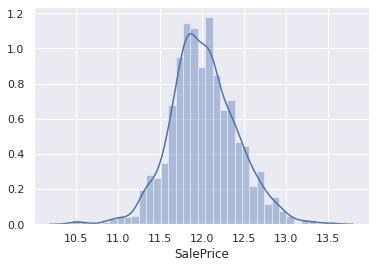

In [141]:
### Let us check if it is now normally distributed or not
sns.distplot(salePriceLogTransform)

The skewness after Square Root Transform: 0.943153


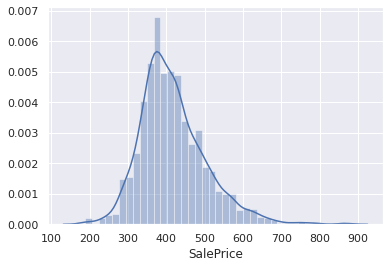

In [142]:
# checking the Square Root Transform

salePriceSQRT = np.sqrt(housingDataSetDroppedColumns['SalePrice'])

print("The skewness after Square Root Transform: %f" %salePriceSQRT.skew())
sns.distplot(salePriceSQRT)

The skewness after Log1p Transform: 0.121347


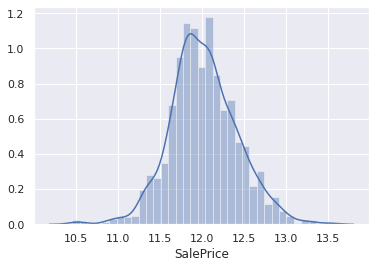

In [143]:
# checking the Log1p Transform

salePriceLog1P = np.log1p(housingDataSetDroppedColumns['SalePrice'])

print("The skewness after Log1p Transform: %f" %salePriceLog1P.skew())
sns.distplot(salePriceLog1P)

### Observation

We get the best results when we do log transform on the saleprice variable.

In [144]:
housingDataSetDroppedColumns.SalePrice = np.log(housingDataSetDroppedColumns.SalePrice)
print("The skewness after Log Transform is: %f" %salePriceLogTransform.skew())


The skewness after Log Transform is: 0.121335


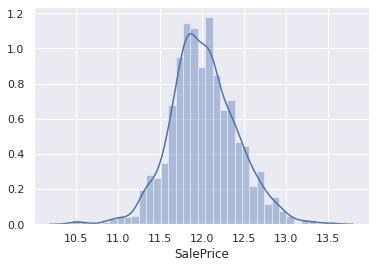

In [145]:
sns.distplot(housingDataSetDroppedColumns.SalePrice)

### Outlier Treatment

We will now perform outlier treatment on continuous variable

In [146]:
housingDataSetDroppedColumnsContVars = housingDataSetDroppedColumns.select_dtypes(include=['int64','float64'])
housingDataSetDroppedColumnsContVars.head()

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0         65.0     8450       196.0         706           0        150   
1         80.0     9600         0.0         978           0        284   
2         68.0    11250       162.0         486           0        434   
3         60.0     9550         0.0         216           0        540   
4         84.0    14260       350.0         655           0        490   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  GarageArea  \
0          856       856       854             0       1710         548   
1         1262      1262         0             0       1262         460   
2          920       920       866             0       1786         608   
3          756       961       756             0       1717         642   
4         1145      1145      1053             0       2198         836   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0           0           61              0          0            0         0   
1         298            0              0          0            0         0   
2           0           42              0          0            0         0   
3           0           35            272          0            0         0   
4         192           84              0          0            0         0   

   MiscVal  SalePrice  Age_SinceConstruction  Age_Remodel  Age_Garage  \
0        0  12.247694                     17           17        17.0   
1        0  12.109011                     44           44        44.0   
2        0  12.317167                     19           18        19.0   
3        0  11.849398                    105           50        22.0   
4        0  12.429216                     20           20        20.0   

   Age_SinceSold  
0             12  
1             13  
2             12  
3             14  
4             12

In [147]:
housingDataSetDroppedColumnsContVars.shape

(1460, 24)

In [148]:
vars_outlier_treatment = list(housingDataSetDroppedColumnsContVars.columns)
vars_outlier_treatment.remove('SalePrice')
vars_outlier_treatment

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'Age_SinceConstruction',
 'Age_Remodel',
 'Age_Garage',
 'Age_SinceSold']

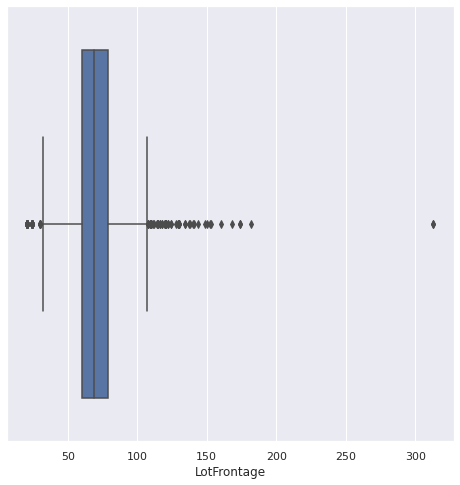

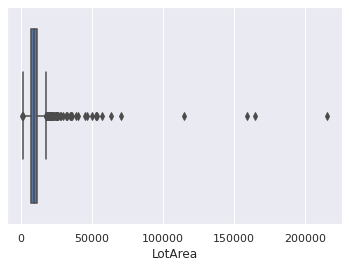

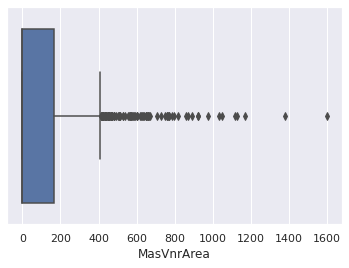

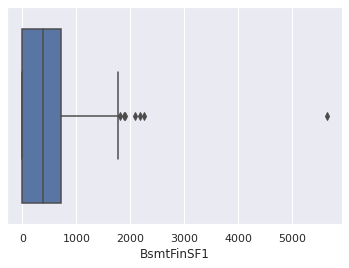

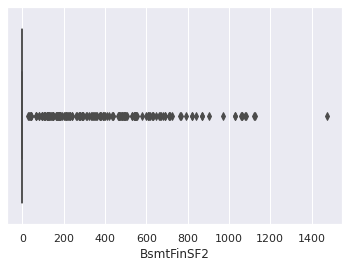

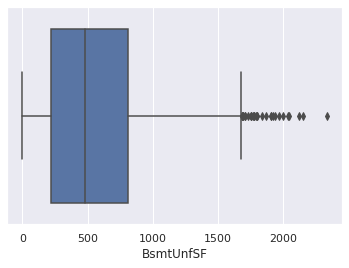

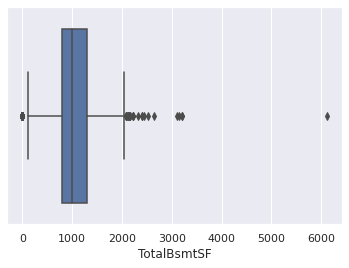

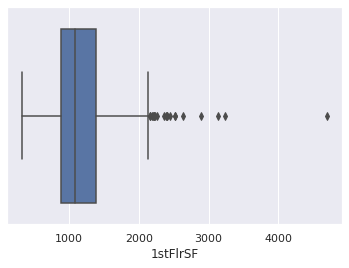

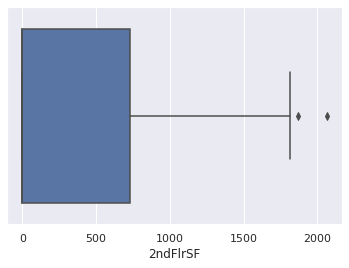

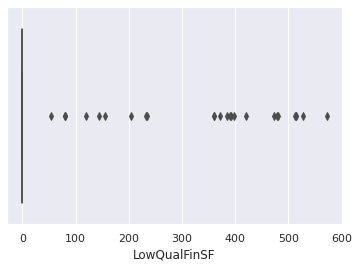

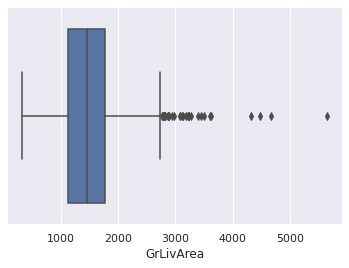

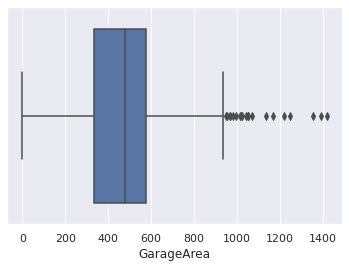

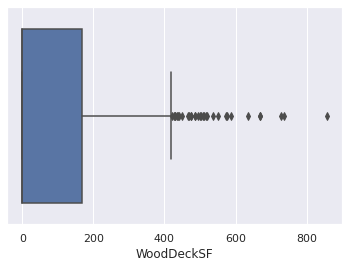

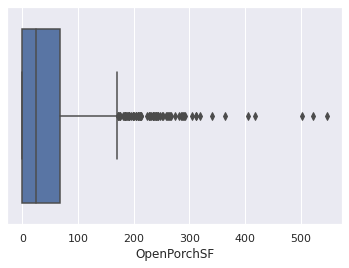

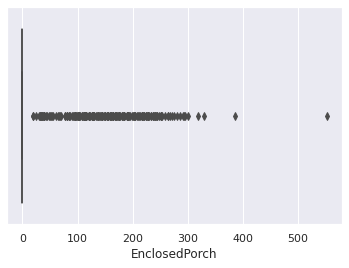

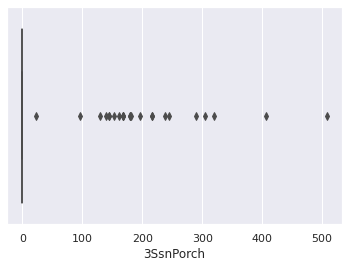

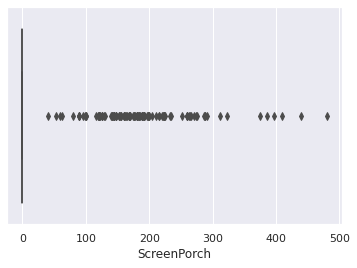

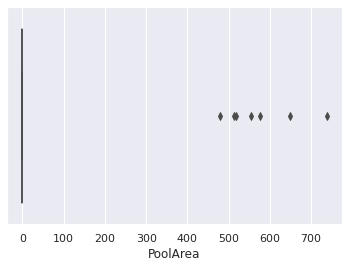

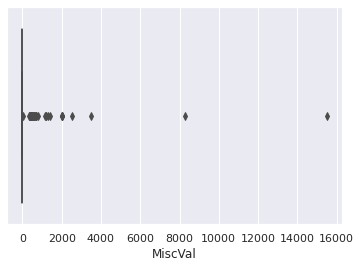

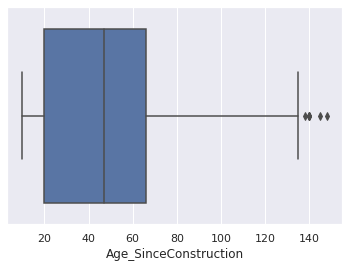

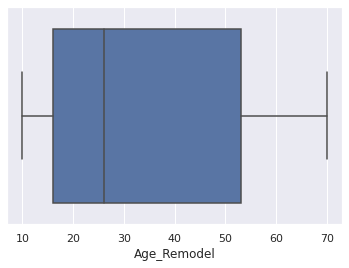

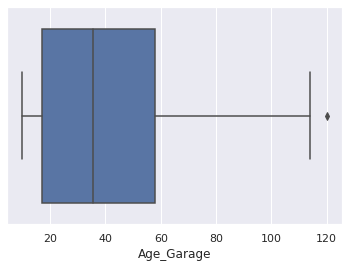

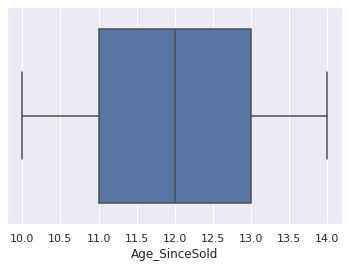

In [149]:
### Generating boxplots for continous variables

plt.figure(figsize=(8,8))

for i in range(0,len(vars_outlier_treatment)):
    sns.boxplot(housingDataSetDroppedColumnsContVars[vars_outlier_treatment[i]])
    plt.show()

### Observation

From the box plots above we can see that 2 variables dont have any outliers, we will remove them from the list.

In [150]:
vars_outlier_treatment.remove('Age_SinceSold')
vars_outlier_treatment.remove('Age_Remodel')
vars_outlier_treatment

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'Age_SinceConstruction',
 'Age_Garage']

In [151]:
### We will cap our data at the 95% mark so as to not lose any values or drop rows. 

for item in vars_outlier_treatment:
    capValue = housingDataSetDroppedColumnsContVars[item].quantile(0.95)
    housingDataSetDroppedColumnsContVars[item][housingDataSetDroppedColumnsContVars[item] >= capValue] = capValue


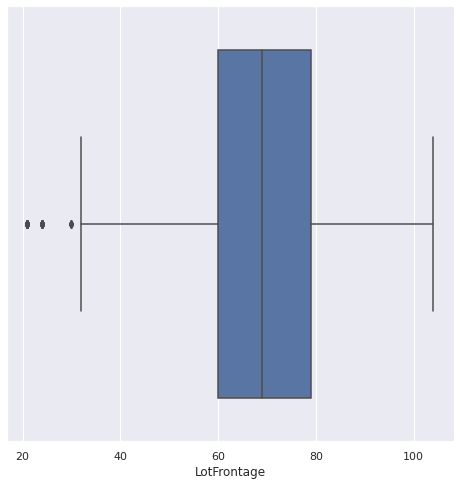

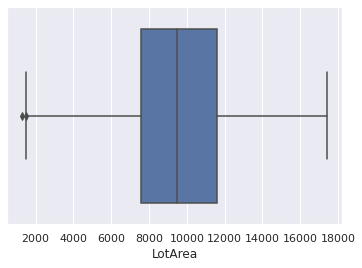

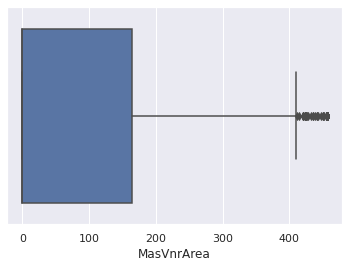

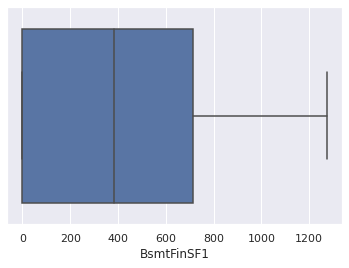

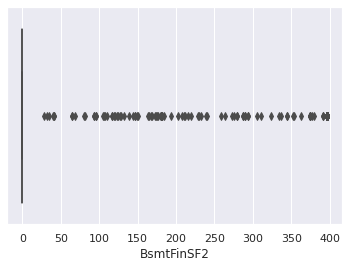

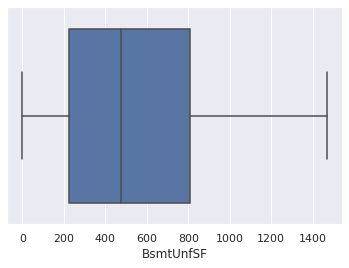

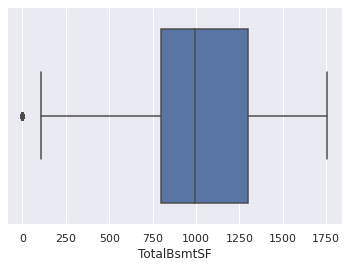

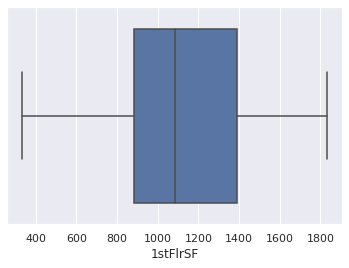

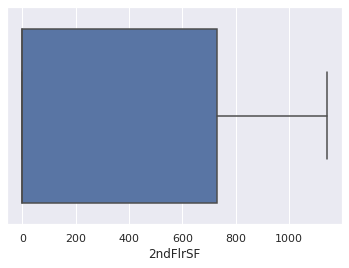

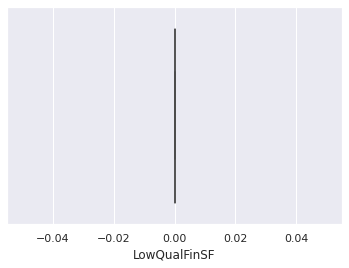

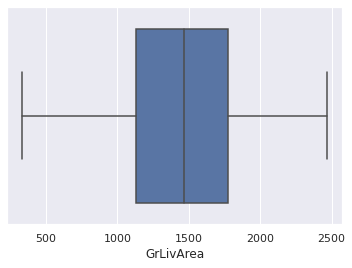

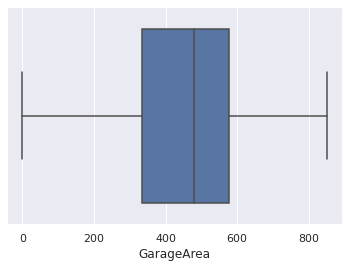

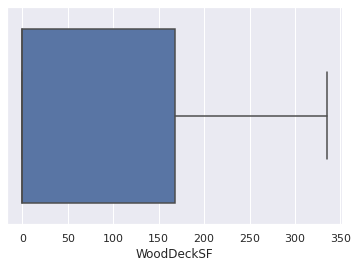

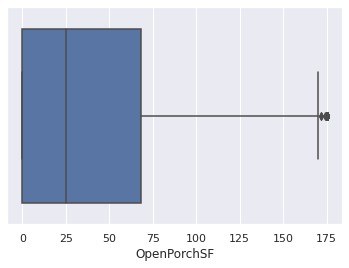

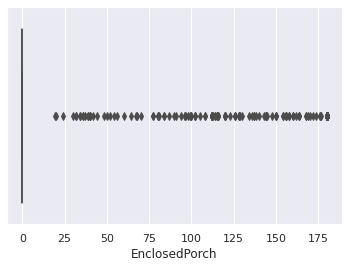

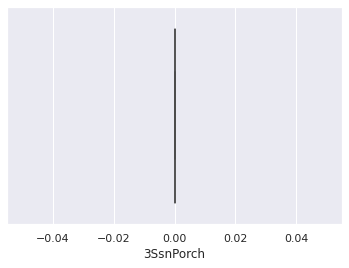

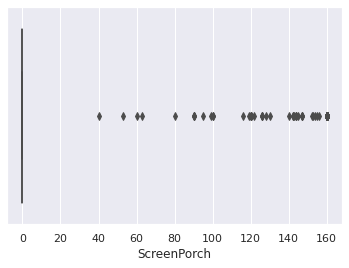

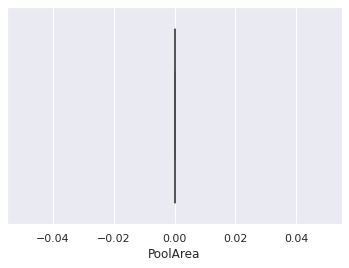

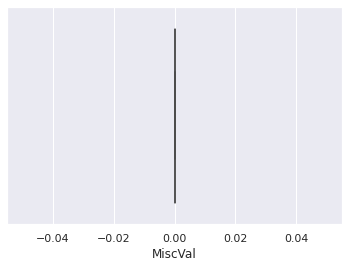

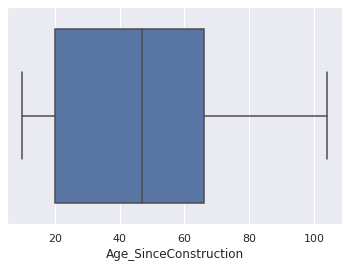

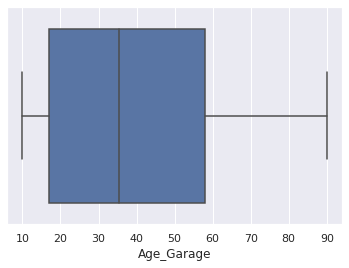

In [152]:
### Generating boxplots for continous variables

plt.figure(figsize=(8,8))

for i in range(0,len(vars_outlier_treatment)):
    sns.boxplot(housingDataSetDroppedColumnsContVars[vars_outlier_treatment[i]])
    plt.show()

### Observation

From the boxplots above we can see that the outliers have been correctly treated. 

# 2. Data Preparation 

### Creating Dummy Variables

In [153]:
# creating dummy variables for categorical variables

# subset all categorical variables
housingDataSetDroppedColumnsCategoricalVars = housingDataSetDroppedColumns.select_dtypes(include=['object'])
housingDataSetDroppedColumnsCategoricalVars.head()

MSSubClass MSZoning LotShape LotConfig Neighborhood HouseStyle OverallQual  \
0         60       RL      Reg    Inside      CollgCr     2Story           7   
1         20       RL      Reg       FR2      Veenker     1Story           6   
2         60       RL      IR1    Inside      CollgCr     2Story           7   
3         70       RL      IR1    Corner      Crawfor     2Story           7   
4         60       RL      IR1       FR2      NoRidge     2Story           8   

  OverallCond RoofStyle Exterior1st Exterior2nd MasVnrType ExterQual  \
0           5     Gable     VinylSd     VinylSd    BrkFace        Gd   
1           8     Gable     MetalSd     MetalSd       None        TA   
2           5     Gable     VinylSd     VinylSd    BrkFace        Gd   
3           5     Gable     Wd Sdng     Wd Shng       None        TA   
4           5     Gable     VinylSd     VinylSd    BrkFace        Gd   

  Foundation BsmtQual BsmtExposure BsmtFinType1 HeatingQC BsmtFullBath  \
0      PConc       Gd           No          GLQ        Ex            1   
1     CBlock       Gd           Gd          ALQ        Ex            0   
2      PConc       Gd           Mn          GLQ        Ex            1   
3     BrkTil       TA           No          ALQ        Gd            1   
4      PConc       Gd           Av          GLQ        Ex            1   

  FullBath HalfBath BedroomAbvGr KitchenQual TotRmsAbvGrd Fireplaces  \
0        2        1            3          Gd            8          0   
1        2        0            3          TA            6          1   
2        2        1            3          Gd            6          1   
3        1        0            3          Gd            7          1   
4        2        1            4          Gd            9          1   

  FireplaceQu GarageType GarageFinish GarageCars  
0          No     Attchd          RFn          2  
1          TA     Attchd          RFn          2  
2          TA     Attchd          RFn          2  
3          Gd     Detchd          Unf          3  
4          TA     Attchd          RFn          3

In [154]:
housingDataSetDroppedColumnsCategoricalVars.shape

(1460, 29)

In [155]:
housingDataSetDroppedColumnsContVars.head()

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0         65.0   8450.0       196.0         706         0.0        150   
1         80.0   9600.0         0.0         978         0.0        284   
2         68.0  11250.0       162.0         486         0.0        434   
3         60.0   9550.0         0.0         216         0.0        540   
4         84.0  14260.0       350.0         655         0.0        490   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  GarageArea  \
0          856     856.0     854.0             0     1710.0       548.0   
1         1262    1262.0       0.0             0     1262.0       460.0   
2          920     920.0     866.0             0     1786.0       608.0   
3          756     961.0     756.0             0     1717.0       642.0   
4         1145    1145.0    1053.0             0     2198.0       836.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0           0         61.0           0.00          0            0         0   
1         298          0.0           0.00          0            0         0   
2           0         42.0           0.00          0            0         0   
3           0         35.0         180.15          0            0         0   
4         192         84.0           0.00          0            0         0   

   MiscVal  SalePrice  Age_SinceConstruction  Age_Remodel  Age_Garage  \
0        0  12.247694                     17           17        17.0   
1        0  12.109011                     44           44        44.0   
2        0  12.317167                     19           18        19.0   
3        0  11.849398                    104           50        22.0   
4        0  12.429216                     20           20        20.0   

   Age_SinceSold  
0             12  
1             13  
2             12  
3             14  
4             12

In [156]:
housingDataSetDroppedColumnsCategoricalVars.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars'],
      dtype='object')

In [157]:
housingDataSetDroppedColumns.shape

(1460, 53)

In [158]:
### Creating dummies
df_dummies = pd.get_dummies(housingDataSetDroppedColumnsCategoricalVars, drop_first=True)
df_dummies.head()

MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  \
0              0              0              0              0              1   
1              0              0              0              0              0   
2              0              0              0              0              1   
3              0              0              0              0              0   
4              0              0              0              0              1   

   MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              1              0              0              0              0   
4              0              0              0              0              0   

   MSSubClass_120  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  LotShape_IR2  \
0            0            0            1            0             0   
1            0            0            1            0             0   
2            0            0            1            0             0   
3            0            0            1            0             0   
4            0            0            1            0             0   

   LotShape_IR3  LotShape_Reg  LotConfig_CulDSac  LotConfig_FR2  \
0             0             1                  0              0   
1             0             1                  0              1   
2             0             0                  0              0   
3             0             0                  0              0   
4             0             0                  0              1   

   LotConfig_FR3  LotConfig_Inside  Neighborhood_Blueste  Neighborhood_BrDale  \
0              0                 1                     0                    0   
1              0                 0                     0                    0   
2              0                 1                     0                    0   
3              0                 0                     0                    0   
4              0                 0                     0                    0   

   Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  \
0                     0                     0                     1   
1                     0                     0                     0   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     0   

   Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     1                     0                     0   
4                     0                     0                     0   

   Neighborhood_IDOTRR  Neighborhood_MeadowV  Neighborhood_Mitchel  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     0   
3                    0                     0                     0   
4                    0                     0                     0   

   Neighborhood_NAmes  Neighborhoo

In [159]:
df_dummies.shape

(1460, 185)

In [160]:
# drop categorical variables 

housingDataSetDroppedColumns = housingDataSetDroppedColumns.drop(list(housingDataSetDroppedColumnsCategoricalVars.columns), axis=1)
housingDataSetDroppedColumns.shape

(1460, 24)

In [161]:
housingDataSetDroppedColumns = pd.concat([housingDataSetDroppedColumns, df_dummies], axis=1)

In [162]:
housingDataSetDroppedColumns.shape

(1460, 209)

# Modelling and Training


#### Train Test Split

In [163]:
### We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(housingDataSetDroppedColumns, train_size = 0.7, test_size = 0.3, random_state = 100)

In [164]:
### Performing Min-Max Scalling

scaler = MinMaxScaler()

In [165]:
# checking all the continuous variables
list(housingDataSetDroppedColumnsContVars.columns)

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice',
 'Age_SinceConstruction',
 'Age_Remodel',
 'Age_Garage',
 'Age_SinceSold']

In [166]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables and target variable

num_vars = list(housingDataSetDroppedColumnsContVars.columns)
num_vars.remove('SalePrice')

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_train.head()


LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
210      0.157534  0.019306        0.00    0.082920         0.0   0.169521   
318      0.236301  0.039403        0.16    0.174876         0.0   0.154110   
239      0.106164  0.033981        0.00    0.016655         0.0   0.274401   
986      0.130137  0.017931        0.00    0.000000         0.0   0.207620   
1416     0.133562  0.046139        0.00    0.000000         0.0   0.332620   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  GarageArea  \
210      0.141408  0.113889  0.000000           0.0   0.081860    0.000000   
318      0.220458  0.231481  0.616949           0.0   0.424289    0.462623   
239      0.120295  0.098611  0.333656           0.0   0.201576    0.155148   
986      0.079378  0.145602  0.307022           0.0   0.230015    0.179831   
1416     0.127169  0.202315  0.505569           0.0   0.355880    0.394922   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
210     0.000000     0.000000       0.173913        0.0          0.0   
318     0.396733     0.114723       0.260870        0.0          0.0   
239     0.000000     0.267686       0.000000        0.0          0.0   
986     0.459743     0.000000       0.000000        0.0          0.0   
1416    0.000000     0.000000       0.206522        0.0          0.0   

      PoolArea  MiscVal  SalePrice  Age_SinceConstruction  Age_Remodel  \
210        0.0      0.0  11.492723               0.615942     1.000000   
318        0.0      0.0  12.468437               0.123188     0.283333   
239        0.0      0.0  11.635143               0.471014     1.000000   
986        0.0      0.0  11.669929               0.724638     0.116667   
1416       0.0      0.0  11.715866               0.905797     1.000000   

      Age_Garage  Age_SinceSold  MSSubClass_30  MSSubClass_40  MSSubClass_45  \
210     0.045455           0.50              1              0              0   
318     0.154545           0.25              0              0              0   
239     0.554545           0.00              0              0              0   
986     0.545455           1.00              0              0              0   
1416    0.354545           0.00              0              0              0   

      MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  \
210               0              0              0              0   
318               0              1              0              0   
239               1              0              0              0   
986               1              0              0              0   
1416              0              0              0              0   

      MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
210               0              0              0               0   
318               0              0              0               0   
239               0              0              0               0   
986               0              0              0               0   
1416              0              0              0               0   

      MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_FV  \
210                0               0               0            0   
318                0               0               0            0   
239                0               0               0            0   
986                0               0               0            0   
1416               0               0               1            0   

      MSZoning_RH  MSZoning_RL  MSZoning_RM  LotShape_IR2  LotShape_IR3  \
210             0            1            0             0             0   
318             0            1            0             0             0   
239             0            1            0             0             0   
986             0            0            1             0             0   
1416            0            0            1             0             0   

      LotShape_Reg 

### Creating X & Y sets for modelling


In [167]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [168]:
y_test = df_test.pop('SalePrice')
X_test = df_test

### Model Building

### RFE

Using RFE to utilise only 50 features instead of 210

In [169]:
# Running RFE with the output number of the variable equal to 50
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 50)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [170]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 22),
 ('LotArea', True, 1),
 ('MasVnrArea', False, 115),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('GarageArea', False, 37),
 ('WoodDeckSF', False, 49),
 ('OpenPorchSF', False, 158),
 ('EnclosedPorch', False, 55),
 ('3SsnPorch', False, 23),
 ('ScreenPorch', False, 56),
 ('PoolArea', True, 1),
 ('MiscVal', False, 154),
 ('Age_SinceConstruction', True, 1),
 ('Age_Remodel', False, 24),
 ('Age_Garage', False, 94),
 ('Age_SinceSold', False, 132),
 ('MSSubClass_30', False, 31),
 ('MSSubClass_40', False, 20),
 ('MSSubClass_45', False, 91),
 ('MSSubClass_50', False, 131),
 ('MSSubClass_60', False, 63),
 ('MSSubClass_70', False, 128),
 ('MSSubClass_75', False, 88),
 ('MSSubClass_80', False, 125),
 ('MSSubClass_85', False, 117),
 ('MSSubClass_90', False, 92),
 ('MSSubClass_120', False, 57),
 ('MSSubClass_160',

In [171]:
col = X_train.columns[rfe.support_]
col

Index(['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'PoolArea',
       'Age_SinceConstruction', 'MSZoning_FV', 'OverallQual_2',
       'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8',
       'OverallQual_9', 'OverallQual_10', 'OverallCond_2', 'OverallCond_4',
       'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8',
       'OverallCond_9', 'Exterior1st_AsphShn', 'Exterior2nd_AsphShn',
       'BsmtQual_No', 'BsmtFinType1_No', 'BsmtFullBath_3', 'BedroomAbvGr_8',
       'TotRmsAbvGrd_5', 'TotRmsAbvGrd_6', 'TotRmsAbvGrd_7', 'TotRmsAbvGrd_8',
       'TotRmsAbvGrd_9', 'TotRmsAbvGrd_10', 'TotRmsAbvGrd_11',
       'TotRmsAbvGrd_12', 'TotRmsAbvGrd_14', 'Fireplaces_1', 'Fireplaces_2',
       'Fireplaces_3', 'GarageType_No', 'GarageFinish_No', 'GarageCars_1',
       'GarageCars_2', 'GarageCars_3', 'GarageCars_4'],
      dtype='object')

In [172]:
len(col)

50

## Ridge Regression

In [173]:
# Creating X_train dataframe with top 50 RFE selected variables

X_train = X_train[col]
X_test = X_test[col]

In [174]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.0s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [175]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.003670      0.000288         0.002214        0.000105      0.0001   
1       0.003604      0.000128         0.002241        0.000138       0.001   
2       0.003160      0.000333         0.001888        0.000220        0.01   
3       0.002858      0.000114         0.001750        0.000144        0.05   
4       0.002775      0.000036         0.001651        0.000021         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}          -0.099615          -0.109429          -0.106002   
1   {'alpha': 0.001}          -0.099614          -0.109424          -0.106006   
2    {'alpha': 0.01}          -0.099612          -0.109380          -0.106039   
3    {'alpha': 0.05}          -0.099601          -0.109210          -0.106183   
4     {'alpha': 0.1}          -0.099587          -0.109027          -0.106354   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0          -0.094628          -0.104734        -0.102881        0.005193   
1          -0.094627          -0.104731        -0.102880        0.005192   
2          -0.094621          -0.104702        -0.102871        0.005185   
3          -0.094601          -0.104578        -0.102835        0.005160   
4          -0.094591          -0.104435        -0.102799        0.005134   

   rank_test_score  split0_train_score  split1_train_score  \
0                6           -0.098712           -0.088988   
1                5           -0.098714           -0.088990   
2                4           -0.098737           -0.089009   
3                3           -0.098833           -0.089104   
4                1           -0.098957           -0.089226   

   split2_train_score  split3_train_score  split4_train_score  \
0           -0.092696           -0.100174           -0.097396   
1           -0.092699           -0.100175           -0.097400   
2           -0.092722           -0.100192           -0.097437   
3           -0.092825           -0.100263           -0.097600   
4           -0.092960           -0.100351           -0.097803   

   mean_train_score  std_train_score  
0         -0.095593         0.004147  
1         -0.095596         0.004147  
2         -0.095619         0.004148  
3         -0.095725         0.004148  
4         -0.095859         0.004146

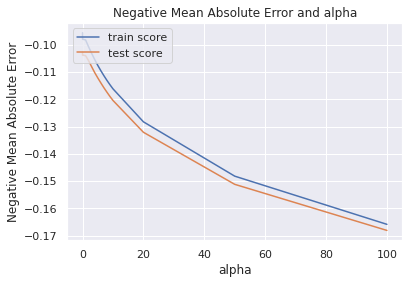

In [176]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [177]:
model_cv.best_params_['alpha']

0.1

### Observation

Based on the above plot of 'Negative Mean Absolute Error and alpha' , the best alpha that we would be selecting here is 0.1

In [178]:
# checking the coefficients generated by this model

ridge = Ridge(alpha=model_cv.best_params_['alpha'])

ridge.fit(X_train, y_train)
ridge.coef_

array([ 0.4441741 ,  0.32751829,  0.09577972, -0.03740028,  0.31134623,
        0.64592172,  0.2061752 ,  0.08156796,  0.62608399, -0.3448971 ,
       -0.51824085,  0.06494831, -0.38506865,  0.05999194,  0.09306724,
        0.19656128,  0.32122368,  0.5059619 ,  0.31793877,  0.05809885,
        0.1405921 ,  0.20172371,  0.26835581,  0.33372519,  0.36690683,
        0.46055345, -0.06134141, -0.06134141, -0.04719444, -0.04719444,
        0.29651375,  0.05693354,  0.03739416,  0.07086275,  0.08024343,
        0.09477727,  0.0963208 ,  0.08203747, -0.14429788, -0.15126617,
        0.05693354,  0.06684329,  0.13055311, -0.25509309, -0.08401043,
       -0.08401043, -0.09119736, -0.03254989,  0.06165002,  0.14610766])

In [179]:
# creating a dataframe to store the values of coeffcients of variables

coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = np.round(pd.Series(ridge.coef_),4)

coeff

0  Coefficient Estimate
0                 LotArea                0.4442
1              BsmtFinSF1                0.3275
2              BsmtFinSF2                0.0958
3               BsmtUnfSF               -0.0374
4             TotalBsmtSF                0.3113
5                1stFlrSF                0.6459
6                2ndFlrSF                0.2062
7            LowQualFinSF                0.0816
8               GrLivArea                0.6261
9                PoolArea               -0.3449
10  Age_SinceConstruction               -0.5182
11            MSZoning_FV                0.0649
12          OverallQual_2               -0.3851
13          OverallQual_5                0.0600
14          OverallQual_6                0.0931
15          OverallQual_7                0.1966
16          OverallQual_8                0.3212
17          OverallQual_9                0.5060
18         OverallQual_10                0.3179
19          OverallCond_2                0.0581
20          OverallCond_4                0.1406
21          OverallCond_5                0.2017
22          OverallCond_6                0.2684
23          OverallCond_7                0.3337
24          OverallCond_8                0.3669
25          OverallCond_9                0.4606
26    Exterior1st_AsphShn               -0.0613
27    Exterior2nd_AsphShn               -0.0613
28            BsmtQual_No               -0.0472
29        BsmtFinType1_No               -0.0472
30         BsmtFullBath_3                0.2965
31         BedroomAbvGr_8                0.0569
32         TotRmsAbvGrd_5                0.0374
33         TotRmsAbvGrd_6                0.0709
34         TotRmsAbvGrd_7                0.0802
35         TotRmsAbvGrd_8                0.0948
36         TotRmsAbvGrd_9                0.0963
37        TotRmsAbvGrd_10                0.0820
38        TotRmsAbvGrd_11               -0.1443
39        TotRmsAbvGrd_12               -0.1513
40        TotRmsAbvGrd_14                0.0569
41           Fireplaces_1                0.0668
42           Fireplaces_2                0.1306
43           Fireplaces_3               -0.2551
44          GarageType_No               -0.0840
45        GarageFinish_No               -0.0840
46           GarageCars_1               -0.0912
47           GarageCars_2               -0.0325
48           GarageCars_3                0.0617
49           GarageCars_4                0.1461

In [180]:
# Coefficients in descending order

coeff.loc[:,'Coefficient Estimate'].sort_values(ascending=False)

5     0.6459
8     0.6261
17    0.5060
25    0.4606
0     0.4442
24    0.3669
23    0.3337
1     0.3275
16    0.3212
18    0.3179
4     0.3113
30    0.2965
22    0.2684
6     0.2062
21    0.2017
15    0.1966
49    0.1461
20    0.1406
42    0.1306
36    0.0963
2     0.0958
35    0.0948
14    0.0931
37    0.0820
7     0.0816
34    0.0802
33    0.0709
41    0.0668
11    0.0649
48    0.0617
13    0.0600
19    0.0581
40    0.0569
31    0.0569
32    0.0374
47   -0.0325
3    -0.0374
28   -0.0472
29   -0.0472
26   -0.0613
27   -0.0613
45   -0.0840
44   -0.0840
46   -0.0912
38   -0.1443
39   -0.1513
43   -0.2551
9    -0.3449
12   -0.3851
10   -0.5182
Name: Coefficient Estimate, dtype: float64

In [181]:
# predict

y_train_pred = ridge.predict(X_train)
print("R_2 Score on Train :  %f" % metrics.r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred = ridge.predict(X_test)
print("R_2 Score on Test :  %f" % metrics.r2_score(y_true=y_test,y_pred=y_test_pred))

print("Mean Sqaured Error : %f" % metrics.mean_squared_error(y_test,y_test_pred))

R_2 Score on Train :  0.875352
R_2 Score on Test :  0.843990
Mean Sqaured Error : 0.025670


In [182]:
def final_model_equation(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 4), name)
                                   for coef, name in lst)

In [183]:
# final model equation - Ridge

final_model_equation(ridge.coef_,  sort = True)

'0.6459 * X5 + 0.6261 * X8 + -0.5182 * X10 + 0.506 * X17 + 0.4606 * X25 + 0.4442 * X0 + -0.3851 * X12 + 0.3669 * X24 + -0.3449 * X9 + 0.3337 * X23 + 0.3275 * X1 + 0.3212 * X16 + 0.3179 * X18 + 0.3113 * X4 + 0.2965 * X30 + 0.2684 * X22 + -0.2551 * X43 + 0.2062 * X6 + 0.2017 * X21 + 0.1966 * X15 + -0.1513 * X39 + 0.1461 * X49 + -0.1443 * X38 + 0.1406 * X20 + 0.1306 * X42 + 0.0963 * X36 + 0.0958 * X2 + 0.0948 * X35 + 0.0931 * X14 + -0.0912 * X46 + -0.084 * X45 + -0.084 * X44 + 0.082 * X37 + 0.0816 * X7 + 0.0802 * X34 + 0.0709 * X33 + 0.0668 * X41 + 0.0649 * X11 + 0.0617 * X48 + -0.0613 * X27 + -0.0613 * X26 + 0.06 * X13 + 0.0581 * X19 + 0.0569 * X40 + 0.0569 * X31 + -0.0472 * X28 + -0.0472 * X29 + -0.0374 * X3 + 0.0374 * X32 + -0.0325 * X47'

### Ridge Modelling Results

- The best alpha = 0.1
- R_2 Score on Train :  0.875352
- R_2 Score on Test :  0.843990
- Mean Squared Error : 0.025670


#### Top 5 features along with their coefficient values are 
- 1stFlrSF	0.6459
- GrLivArea	0.6261
- OverallQual_9	0.5060
- OverallCond_9	0.4606
- LotArea	0.4442 

### Observations

- We have 18 variables out of 50 whose coeefficients are either 0 or lesser than 0.

## Lasso Regression

In [184]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.3s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [185]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.013505      0.000423         0.002414        0.000034      0.0001   
1       0.005476      0.000429         0.002342        0.000197       0.001   
2       0.003882      0.000429         0.002141        0.000065        0.01   
3       0.005085      0.000978         0.003330        0.000144        0.05   
4       0.005234      0.000055         0.003210        0.000037         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}          -0.099216          -0.108318          -0.106955   
1   {'alpha': 0.001}          -0.102507          -0.110400          -0.113005   
2    {'alpha': 0.01}          -0.152894          -0.161899          -0.161744   
3    {'alpha': 0.05}          -0.267482          -0.274322          -0.259336   
4     {'alpha': 0.1}          -0.313295          -0.313484          -0.305876   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0          -0.094120          -0.104170        -0.102556        0.005244   
1          -0.103603          -0.109624        -0.107828        0.004070   
2          -0.148338          -0.165763        -0.158128        0.006463   
3          -0.251965          -0.273461        -0.265313        0.008558   
4          -0.296961          -0.323617        -0.310647        0.008869   

   rank_test_score  split0_train_score  split1_train_score  \
0                1           -0.099023           -0.089083   
1                2           -0.106236           -0.093987   
2                3           -0.156717           -0.156237   
3                4           -0.262162           -0.262805   
4                5           -0.309932           -0.308826   

   split2_train_score  split3_train_score  split4_train_score  \
0           -0.093191           -0.100490           -0.098015   
1           -0.101736           -0.107224           -0.106125   
2           -0.154317           -0.155349           -0.156174   
3           -0.266756           -0.265953           -0.264456   
4           -0.311153           -0.312981           -0.307375   

   mean_train_score  std_train_score  
0         -0.095961         0.004221  
1         -0.103062         0.004917  
2         -0.155759         0.000845  
3         -0.264426         0.001762  
4         -0.310053         0.001922

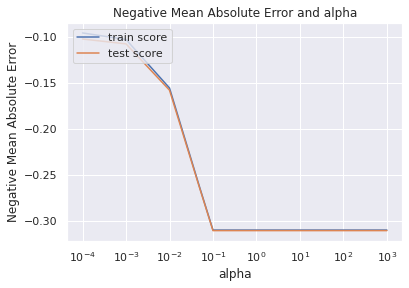

In [186]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.xscale('log')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [187]:
model_cv.best_params_['alpha']

0.0001

### Observation

Based on the above plot of 'Negative Mean Absolute Error and alpha' , the best alpha that we would be selecting here is 0.0001

In [188]:
# fitting the lasso model

lasso = Lasso(alpha=model_cv.best_params_['alpha'])
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [189]:
lasso.coef_

array([ 4.22661790e-01,  4.04814726e-01,  1.11285735e-01, -0.00000000e+00,
        1.85389965e-01,  2.30068935e-01,  0.00000000e+00,  2.77346224e-02,
        1.17544888e+00, -3.20220290e-01, -5.21887003e-01,  6.11169388e-02,
       -3.76670545e-01,  5.60623425e-02,  8.76409191e-02,  1.90845101e-01,
        3.13953032e-01,  4.96879069e-01,  3.01593600e-01,  0.00000000e+00,
        1.04186464e-01,  1.68781834e-01,  2.34462106e-01,  3.01020810e-01,
        3.33279024e-01,  4.20370157e-01, -2.35438516e-02, -4.86198772e-16,
       -1.04871783e-01, -0.00000000e+00,  2.24850245e-01,  0.00000000e+00,
        3.09960234e-02,  6.42944397e-02,  7.16376745e-02,  8.43523356e-02,
        8.26675591e-02,  6.81332064e-02, -1.48648245e-01, -1.50356178e-01,
        2.95692373e-03,  6.76061087e-02,  1.30903127e-01, -2.39914466e-01,
       -1.34810418e-01, -0.00000000e+00, -5.86700247e-02,  0.00000000e+00,
        9.63639527e-02,  1.58476846e-01])

In [190]:
# creating a dataframe to store the values of coeffcients of variables

coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = np.round(pd.Series(lasso.coef_),4)

coeff

0  Coefficient Estimate
0                 LotArea                0.4227
1              BsmtFinSF1                0.4048
2              BsmtFinSF2                0.1113
3               BsmtUnfSF               -0.0000
4             TotalBsmtSF                0.1854
5                1stFlrSF                0.2301
6                2ndFlrSF                0.0000
7            LowQualFinSF                0.0277
8               GrLivArea                1.1754
9                PoolArea               -0.3202
10  Age_SinceConstruction               -0.5219
11            MSZoning_FV                0.0611
12          OverallQual_2               -0.3767
13          OverallQual_5                0.0561
14          OverallQual_6                0.0876
15          OverallQual_7                0.1908
16          OverallQual_8                0.3140
17          OverallQual_9                0.4969
18         OverallQual_10                0.3016
19          OverallCond_2                0.0000
20          OverallCond_4                0.1042
21          OverallCond_5                0.1688
22          OverallCond_6                0.2345
23          OverallCond_7                0.3010
24          OverallCond_8                0.3333
25          OverallCond_9                0.4204
26    Exterior1st_AsphShn               -0.0235
27    Exterior2nd_AsphShn               -0.0000
28            BsmtQual_No               -0.1049
29        BsmtFinType1_No               -0.0000
30         BsmtFullBath_3                0.2249
31         BedroomAbvGr_8                0.0000
32         TotRmsAbvGrd_5                0.0310
33         TotRmsAbvGrd_6                0.0643
34         TotRmsAbvGrd_7                0.0716
35         TotRmsAbvGrd_8                0.0844
36         TotRmsAbvGrd_9                0.0827
37        TotRmsAbvGrd_10                0.0681
38        TotRmsAbvGrd_11               -0.1486
39        TotRmsAbvGrd_12               -0.1504
40        TotRmsAbvGrd_14                0.0030
41           Fireplaces_1                0.0676
42           Fireplaces_2                0.1309
43           Fireplaces_3               -0.2399
44          GarageType_No               -0.1348
45        GarageFinish_No               -0.0000
46           GarageCars_1               -0.0587
47           GarageCars_2                0.0000
48           GarageCars_3                0.0964
49           GarageCars_4                0.1585

In [191]:
# coefficients in descending order

coeff.loc[:,'Coefficient Estimate'].sort_values(ascending=False)

8     1.1754
17    0.4969
0     0.4227
25    0.4204
1     0.4048
24    0.3333
16    0.3140
18    0.3016
23    0.3010
22    0.2345
5     0.2301
30    0.2249
15    0.1908
4     0.1854
21    0.1688
49    0.1585
42    0.1309
2     0.1113
20    0.1042
48    0.0964
14    0.0876
35    0.0844
36    0.0827
34    0.0716
37    0.0681
41    0.0676
33    0.0643
11    0.0611
13    0.0561
32    0.0310
7     0.0277
40    0.0030
47    0.0000
3    -0.0000
19    0.0000
45   -0.0000
27   -0.0000
29   -0.0000
31    0.0000
6     0.0000
26   -0.0235
46   -0.0587
28   -0.1049
44   -0.1348
38   -0.1486
39   -0.1504
43   -0.2399
9    -0.3202
12   -0.3767
10   -0.5219
Name: Coefficient Estimate, dtype: float64

### Observation

- From the above Lasso modelling reults we see that GarageCars_2, GarageFinish_No, Exterior2nd_AsphShn & BsmtFinType1_Noare a few features that have had their coefficients reduced to 0. 
- These features will have no significant impact on the model and are insignificant.

In [192]:
# predict

y_train_pred = lasso.predict(X_train)
print("R_2 Score on Train :  %f" % metrics.r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred = lasso.predict(X_test)
print("R_2 Score on Test :  %f" % metrics.r2_score(y_true=y_test,y_pred=y_test_pred))

print("Mean Sqaured Error : %f" % metrics.mean_squared_error(y_test,y_test_pred))

R_2 Score on Train :  0.874811
R_2 Score on Test :  0.846395
Mean Sqaured Error : 0.025274


In [193]:
# final model equation - Lasso

final_model_equation(lasso.coef_,  sort = True)

'1.1754 * X8 + -0.5219 * X10 + 0.4969 * X17 + 0.4227 * X0 + 0.4204 * X25 + 0.4048 * X1 + -0.3767 * X12 + 0.3333 * X24 + -0.3202 * X9 + 0.314 * X16 + 0.3016 * X18 + 0.301 * X23 + -0.2399 * X43 + 0.2345 * X22 + 0.2301 * X5 + 0.2249 * X30 + 0.1908 * X15 + 0.1854 * X4 + 0.1688 * X21 + 0.1585 * X49 + -0.1504 * X39 + -0.1486 * X38 + -0.1348 * X44 + 0.1309 * X42 + 0.1113 * X2 + -0.1049 * X28 + 0.1042 * X20 + 0.0964 * X48 + 0.0876 * X14 + 0.0844 * X35 + 0.0827 * X36 + 0.0716 * X34 + 0.0681 * X37 + 0.0676 * X41 + 0.0643 * X33 + 0.0611 * X11 + -0.0587 * X46 + 0.0561 * X13 + 0.031 * X32 + 0.0277 * X7 + -0.0235 * X26 + 0.003 * X40 + -0.0 * X27 + -0.0 * X3 + 0.0 * X6 + 0.0 * X19 + -0.0 * X29 + 0.0 * X31 + -0.0 * X45 + 0.0 * X47'

### Lasso Modelling Results and Observations

- The best alpha = 0.0001
- R_2 Score on Train :  0.0.874811
- R_2 Score on Test :  0.0.846395
- Mean Squared Error : 0.0.025274


#### Top 5 features along with their coefficient values are 

- GrLivArea	1.1754
- OverallQual_9	0.4969
- LotArea	0.4227
- OverallCond_9	0.4204
- 1	BsmtFinSF1	0.4048

# Conclusion

From the modelling and splitting we have carried out we can say that:

- Both Ridge & Lasso regression produced similar results for this dataset
- Lasso reduced 1 coefficients to 0, simplifying the model it generated. 
- Ridge reduced 8 coefficients to 0 simplifying the model a lot. 

We will be using Ridge for our final model generation as it generated a simpler model than Lasso.

## Business Insights:

- We can clearly see that the top 5 features to use are the ones from the Ridge model. 
- 1stFlrSF is the most important feature. It highlights that people more concerned with the size of their first floor in a multistory housing.
- People would also like to buy houses that are above ground living area(GrLivArea 0.6261)
-  The overall quality of construction, living area, material finish of the house also matter a lot to the customer (OverallQual_9 0.5060)
- Customers are least interested in the size of the pool and the age of the house.

It is recommended that the company use Ridge regression results to formulate its strategy for breaking into the market and selecting properties to buy.

# End Of File